In [28]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import os
import platform
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'


In [29]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
print(f'Using device: {device}')


Using device: cpu


In [30]:
home_directory = os.path.expanduser('~')
system_type = platform.system()

# デフォルトの OneDrive フォルダ名
onedrive_path = None
if system_type == "Windows":
    # Windows では環境変数が使える（MS公式な方法）
    onedrive_path = os.environ.get("OneDrive")
    if onedrive_path is None:
        # フォールバック
        onedrive_path = os.path.join(home_directory, "OneDrive")
elif system_type == "Darwin": 
    onedrive_path = os.path.join(home_directory, "Library", "CloudStorage", "OneDrive-個人用(2)")

print(f"OneDrive path: {onedrive_path}")


OneDrive path: /Users/konishi/Library/CloudStorage/OneDrive-個人用(2)


In [31]:
# CSVファイルの読み込み
file_path =os.path.join(onedrive_path,'CODES','samples','covtype.csv')
data = pd.read_csv(file_path)

# データの前処理
data = data.dropna()  # 欠損値を削除

# 特徴量とターゲットに分ける
# 'Engine Condition' をターゲット変数として仮定
X = data.drop(columns=['Cover_Type'])
y_origin = data['Cover_Type']-1

# 特徴量を標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)#平均と標準偏差を使ってデータをスケーリング


In [32]:
def get_new_dataloader(X_scaled, y_origin, test_size=0.2, batch_size=512):
    # ランダムに分割（シャッフル付き）
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_origin, test_size=test_size, shuffle=True
    )

    # Tensor変換
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)   # ここだけで十分

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)   # ここだけで十分


    # DataLoader 作成
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [33]:
class Encoder(nn.Module):#PMforCT
    def __init__(self, input_dim, leverage):
        super(Encoder, self).__init__()
        self.leverage = leverage
        output_dim = int(input_dim // leverage)
        phase = torch.rand(output_dim, input_dim) * 2 * np.pi - np.pi
        modulus = torch.rand(output_dim, input_dim)

        real_part = modulus * torch.cos(phase)
        imag_part = modulus * torch.sin(phase)

        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = False

        self.alpha = torch.rand(input_dim) * 0.5 + 0.5  #<<<<<<<<<<<<<<<
        self.alpha = self.alpha.detach().to(device)
        self.alpha.requires_grad = False

    def forward(self, x):
        x = torch.exp(1j * self.alpha * x)
        x = torch.matmul(self.B, x.T).T
        x = torch.abs(x)**2
        return x

In [34]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()

        m1 = min(4 * input_dim, 256)
        m2 = max(m1 // 2, 16)
        self.fc1 = nn.Linear(input_dim, m1)
        self.bn1 = nn.BatchNorm1d(m1)

        self.fc2 = nn.Linear(m1, m2)
        self.bn2 = nn.BatchNorm1d(m2)

        self.fc3 = nn.Linear(m2, 7)

    def forward(self, x):
        x = self.fc1(x) 
        x = self.bn1(x)     
        x = F.relu(x)           
        #x = self.drop1(x)         

        x = self.fc2(x) 
        x = self.bn2(x)      
        x = F.relu(x) 
        #x = self.drop2(x) 

        x = self.fc3(x)   
        return x     


In [35]:
class EncoderClassifier(nn.Module):
    def __init__(self,input_dim, leverage):
        super(EncoderClassifier, self).__init__()
        potential_dim = int(input_dim//leverage)
        self.encoder = Encoder(input_dim,leverage)
        self.classifier =  MLP(potential_dim)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

54


1:1 1th Epoch: 49/50

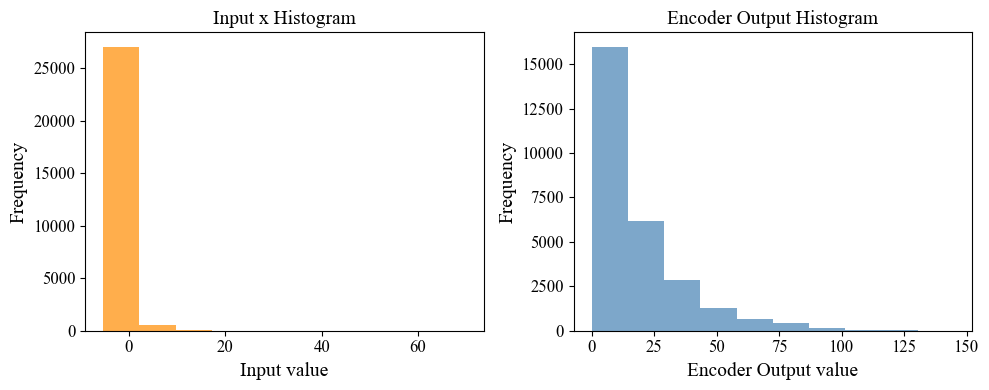

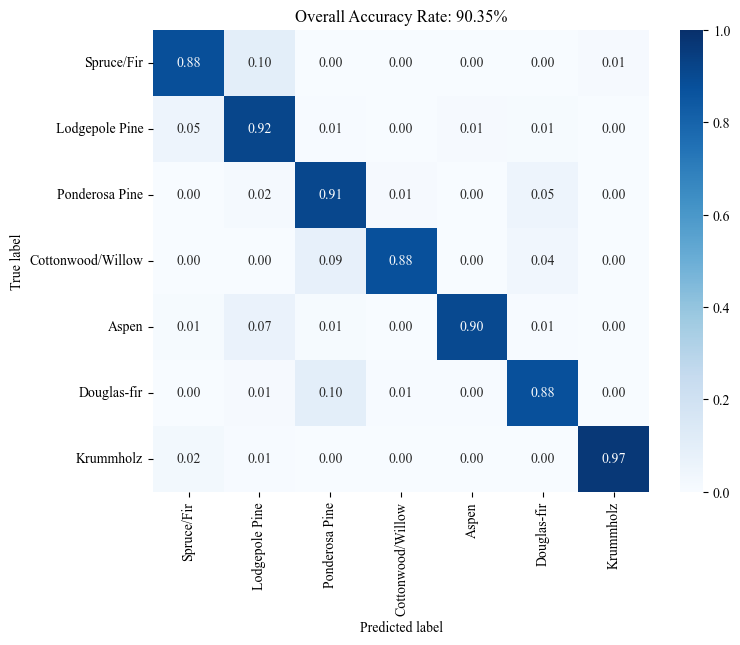

1:1 2th Epoch: 49/50

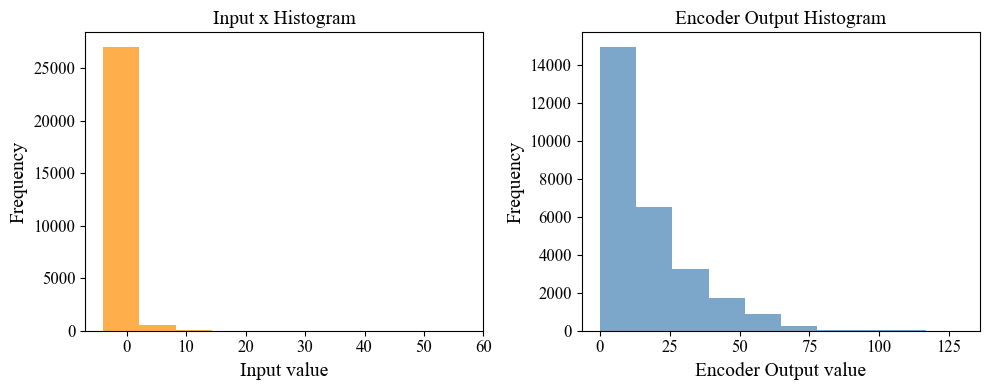

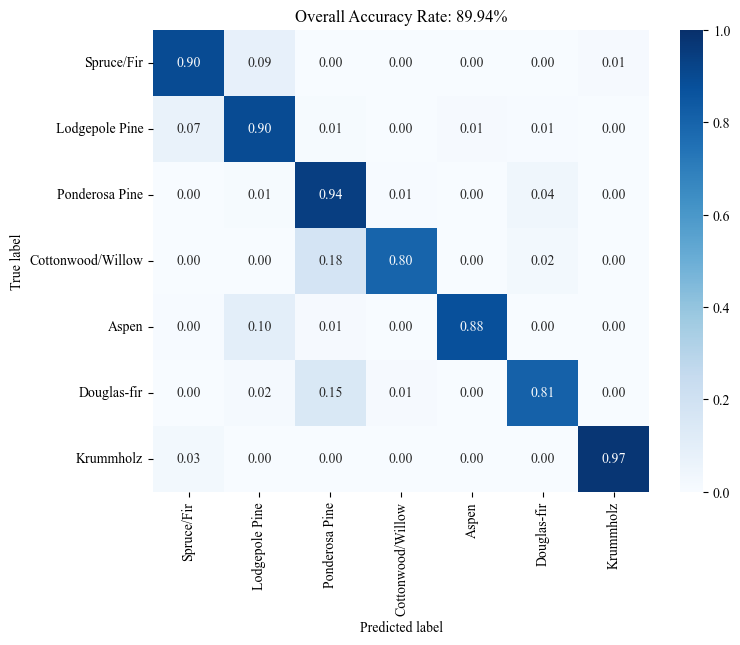

1:1 3th Epoch: 49/50

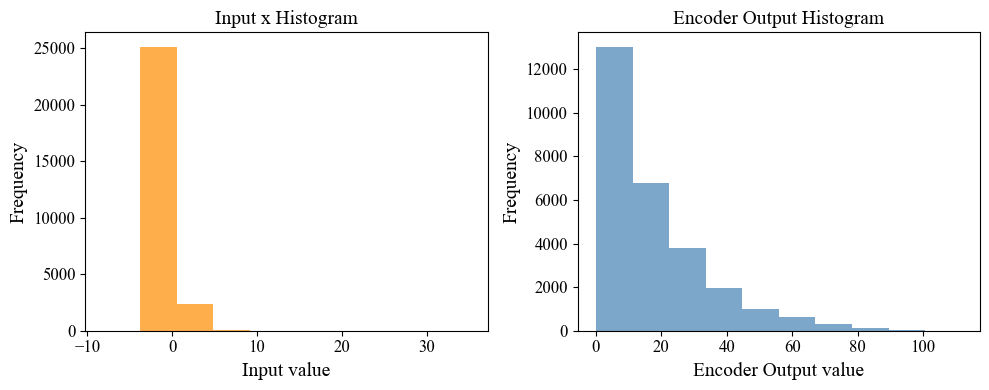

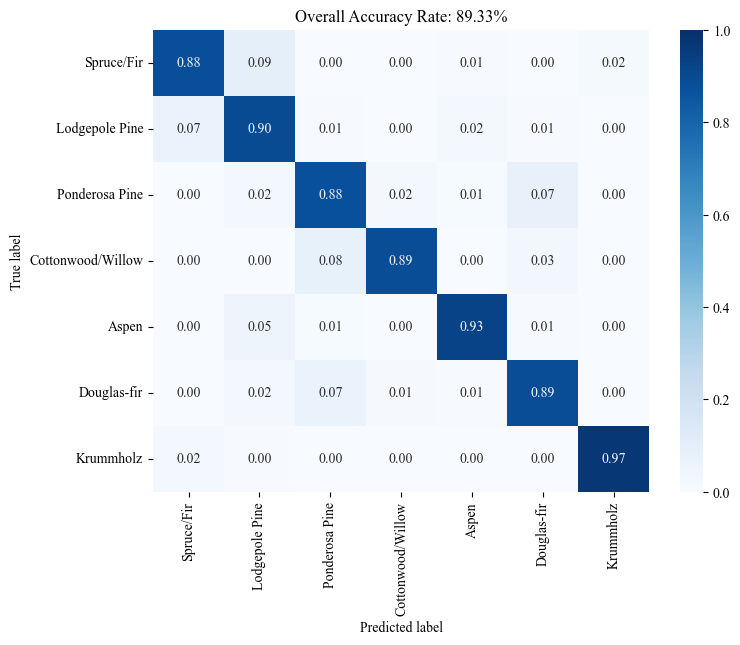

1:1 4th Epoch: 49/50

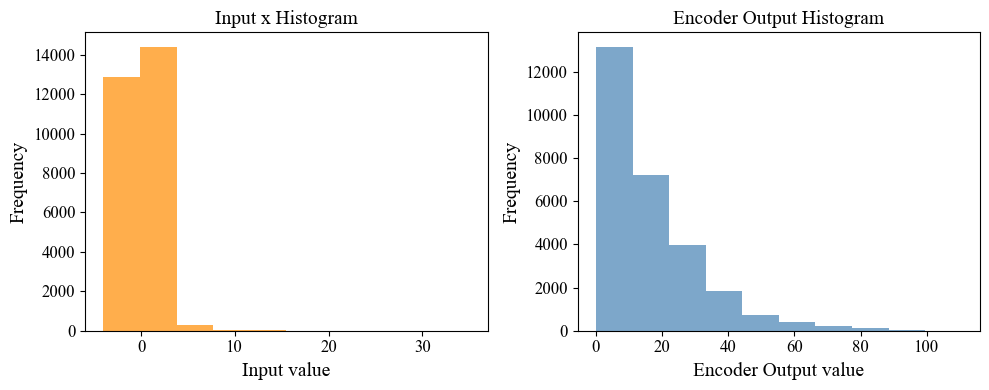

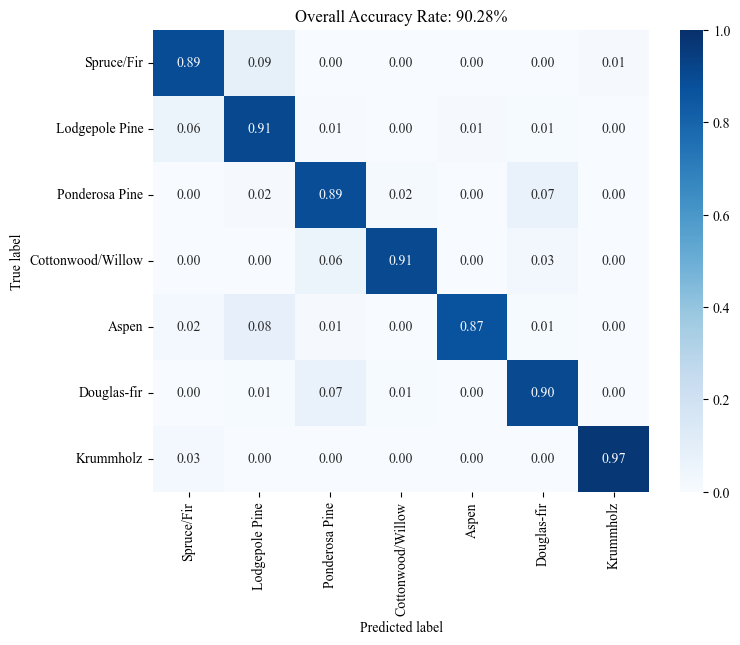

1:1 5th Epoch: 49/50

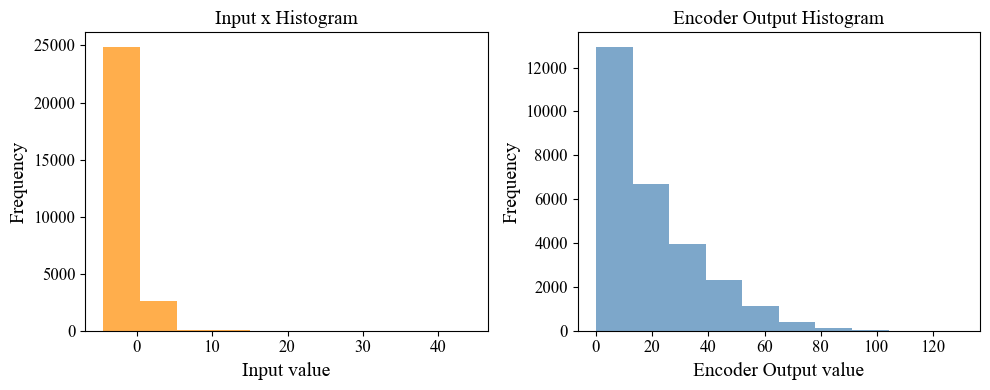

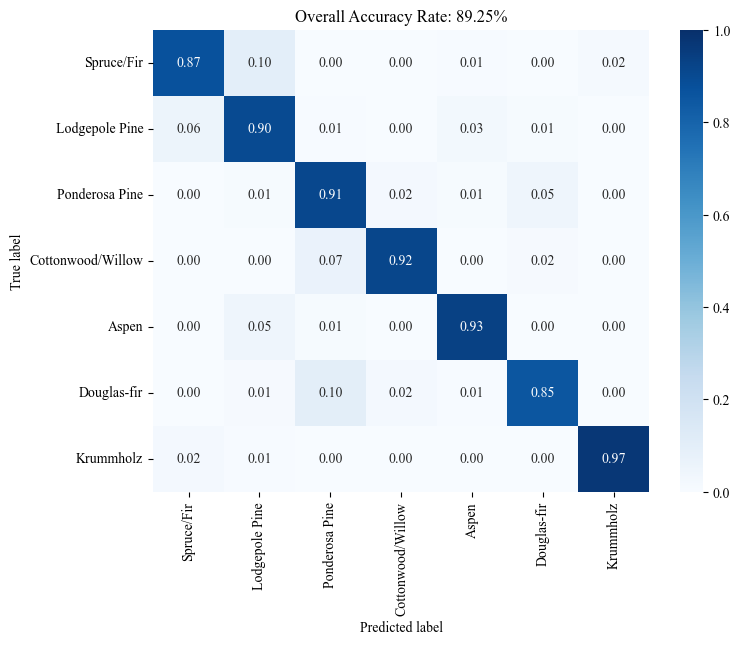

           Average  Best ID       Best  Worst ID      Worst
0   ACC  89.830727        1  90.353950         5  89.250708
1  LOSS   0.838087        1   0.827797         3   0.845328


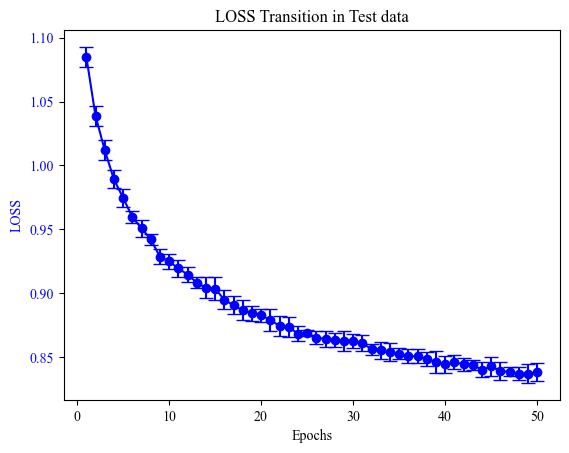

1:2 1th Epoch: 49/50

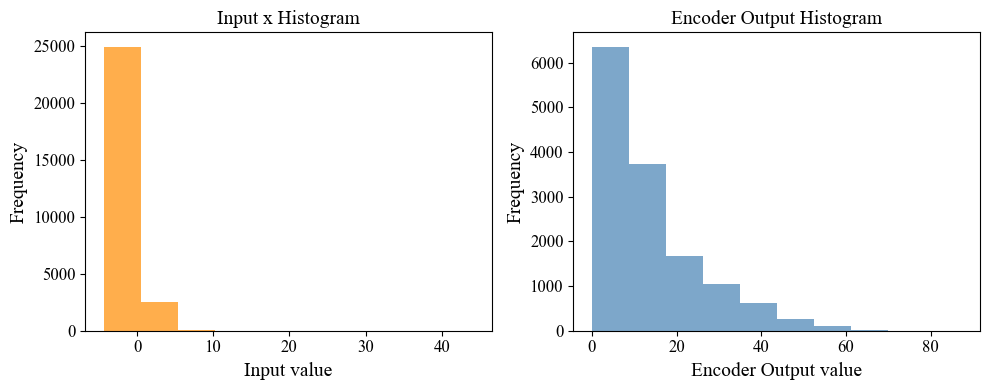

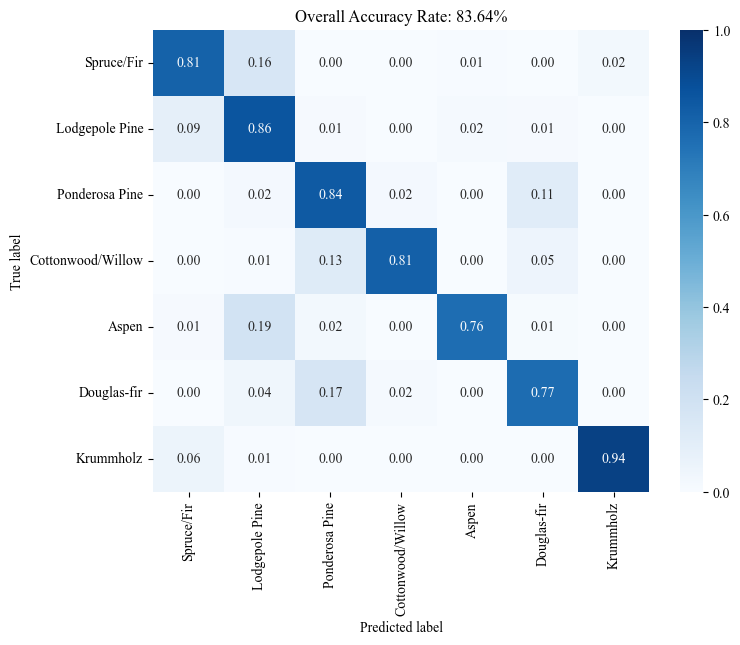

1:2 2th Epoch: 49/50

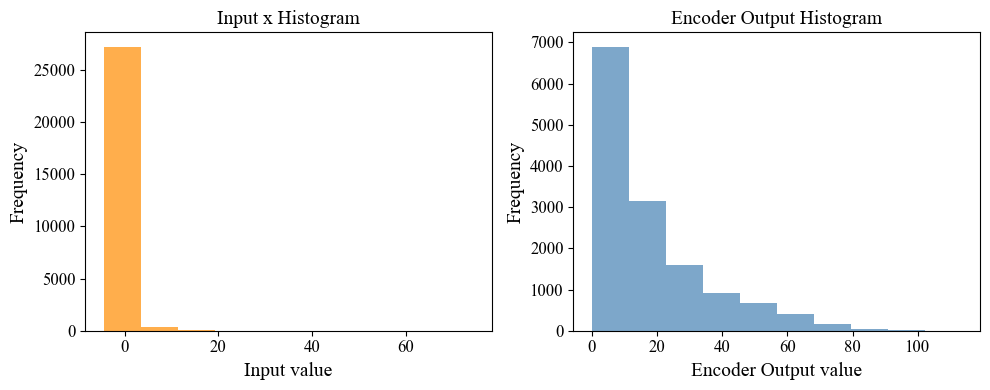

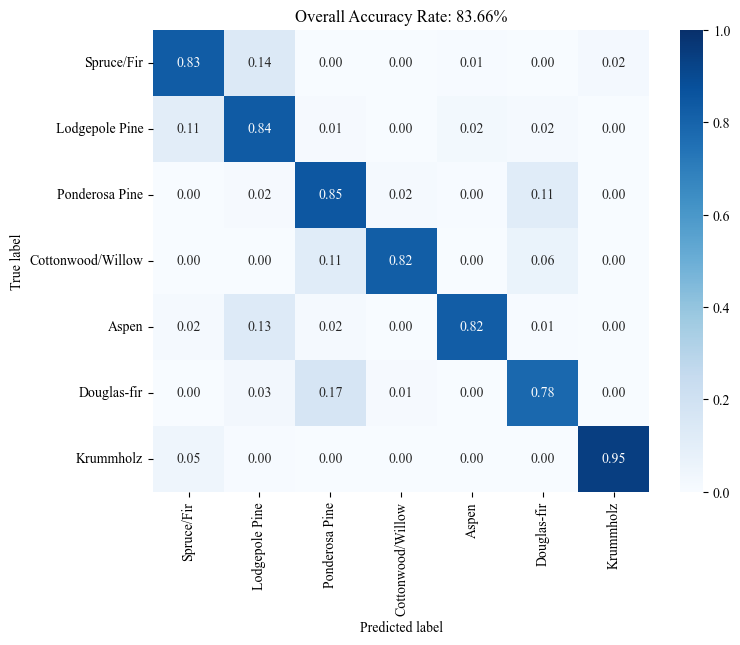

1:2 3th Epoch: 49/50

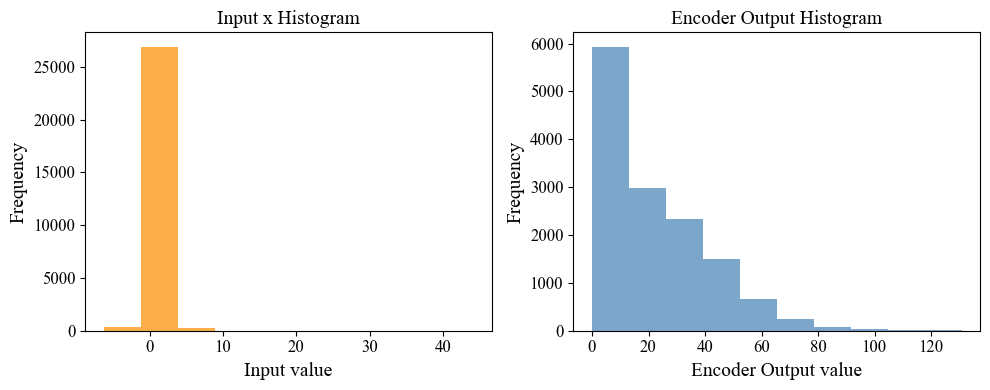

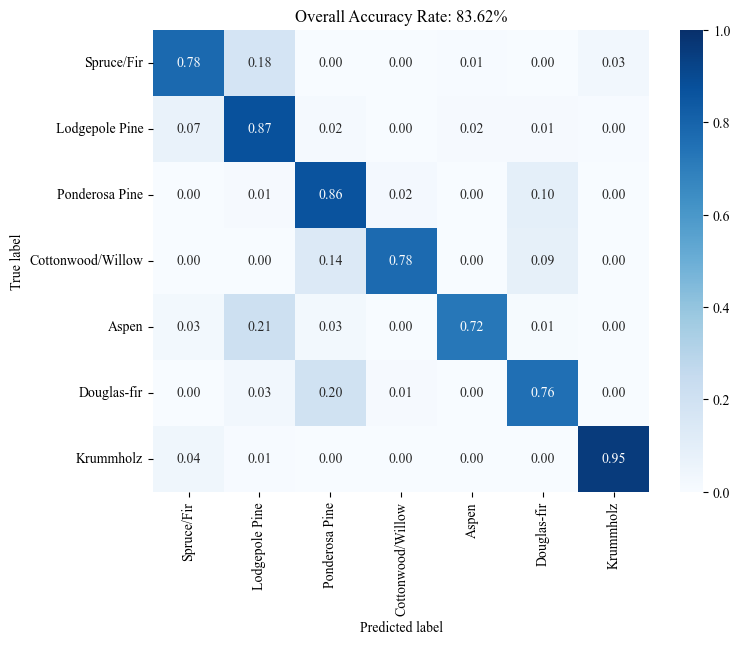

1:2 4th Epoch: 49/50

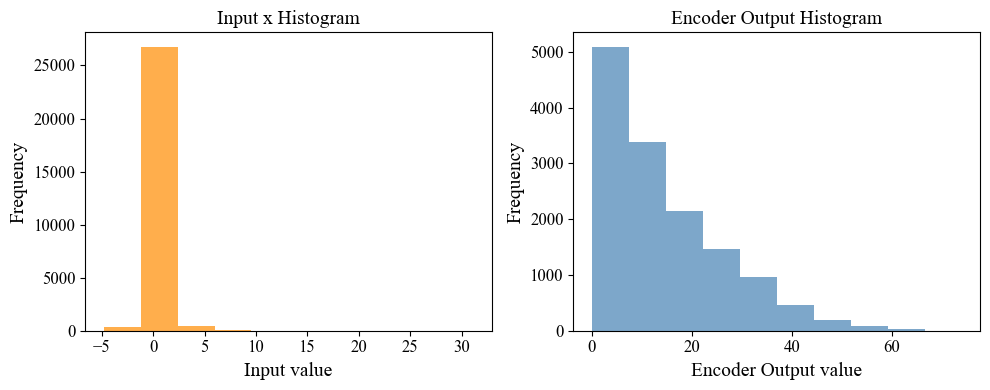

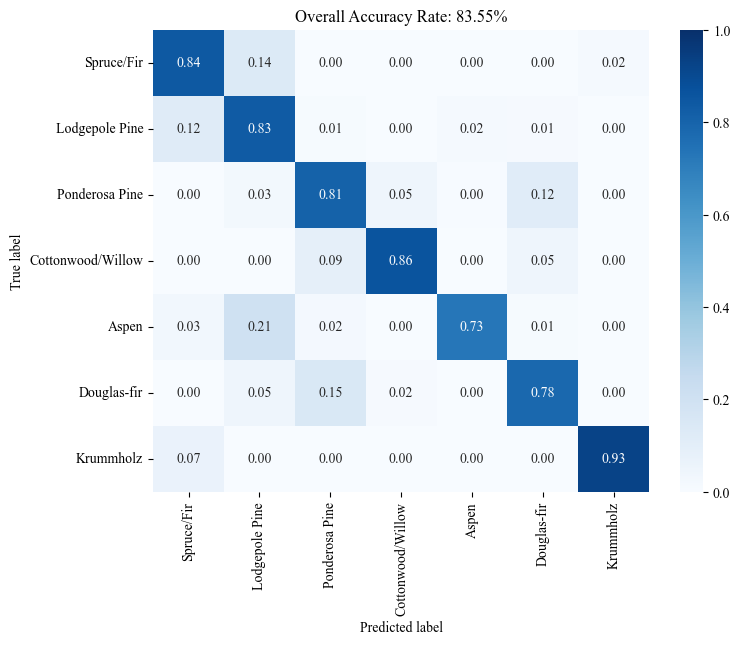

1:2 5th Epoch: 49/50

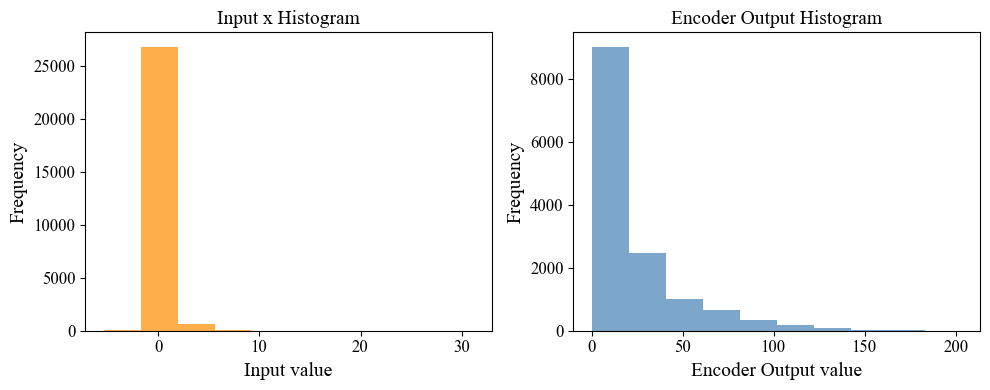

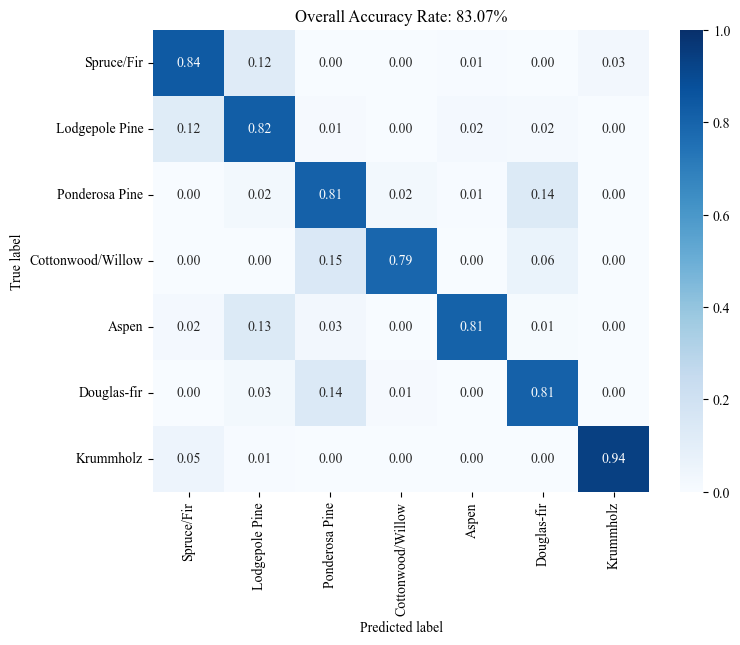

           Average  Best ID       Best  Worst ID      Worst
0   ACC  83.509032        2  83.660491         5  83.072726
1  LOSS   0.972874        2   0.964183         1   0.977686


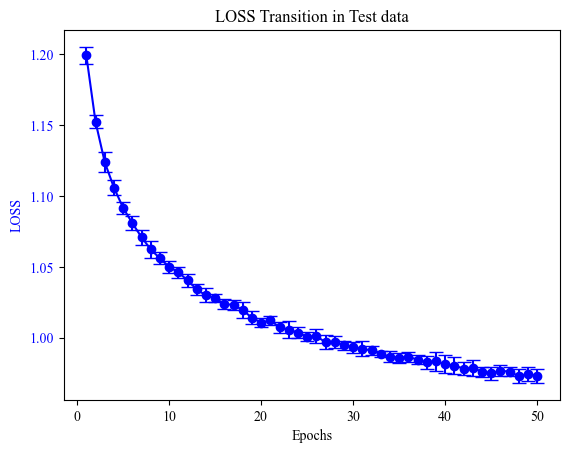

1:3 1th Epoch: 49/50

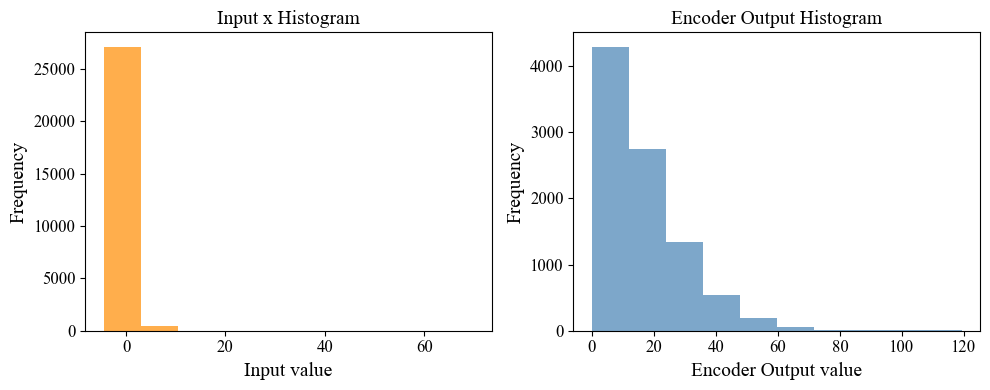

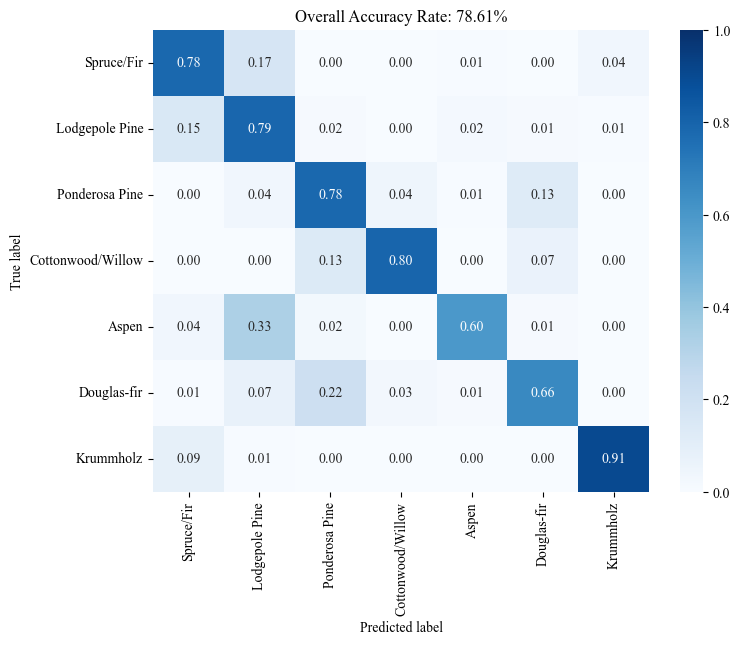

1:3 2th Epoch: 49/50

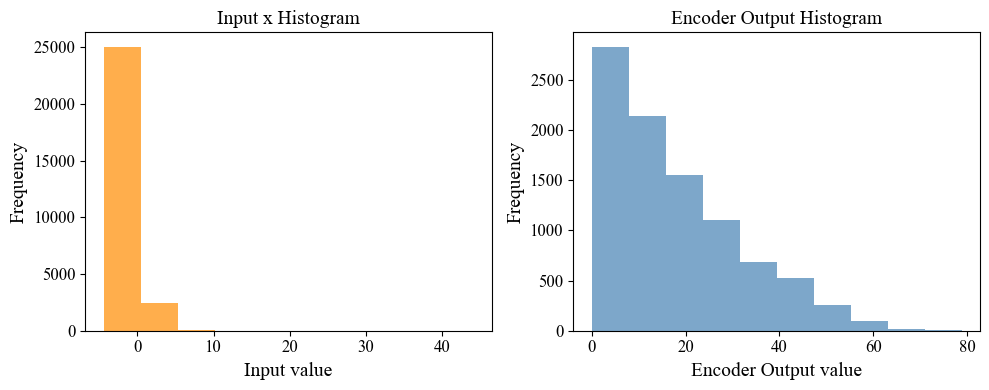

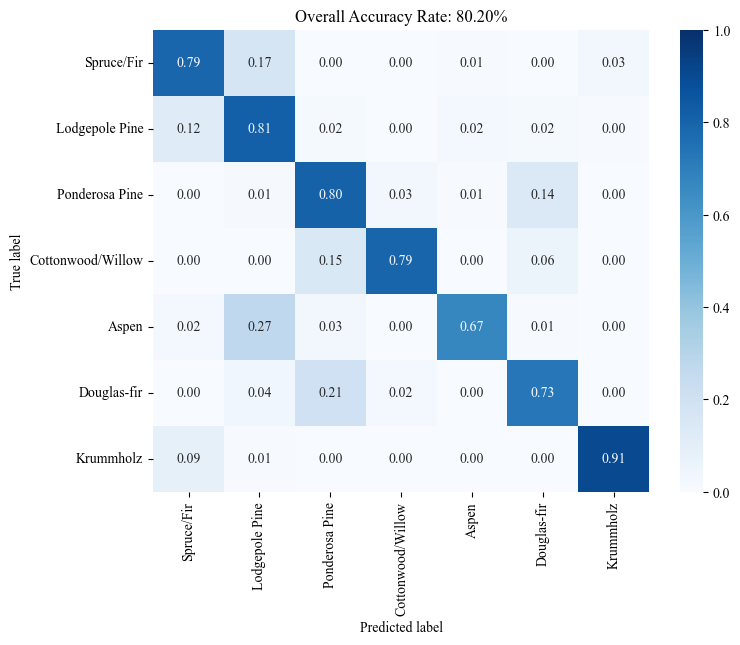

1:3 3th Epoch: 49/50

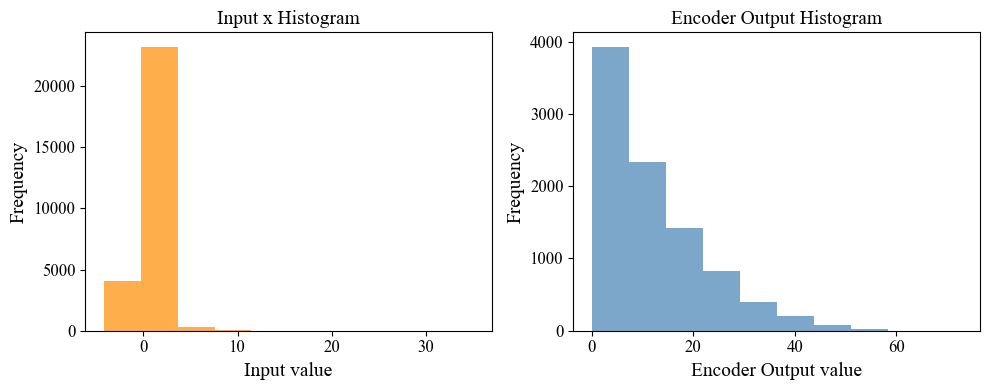

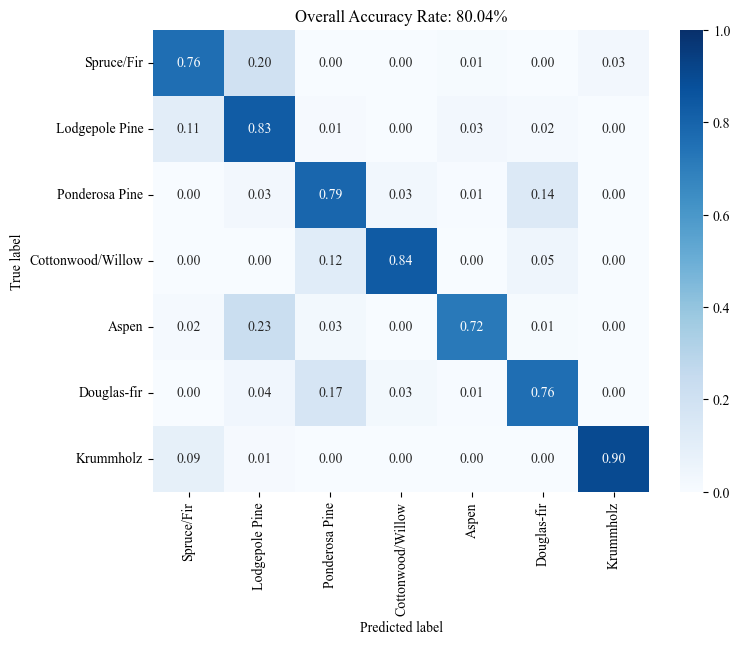

1:3 4th Epoch: 49/50

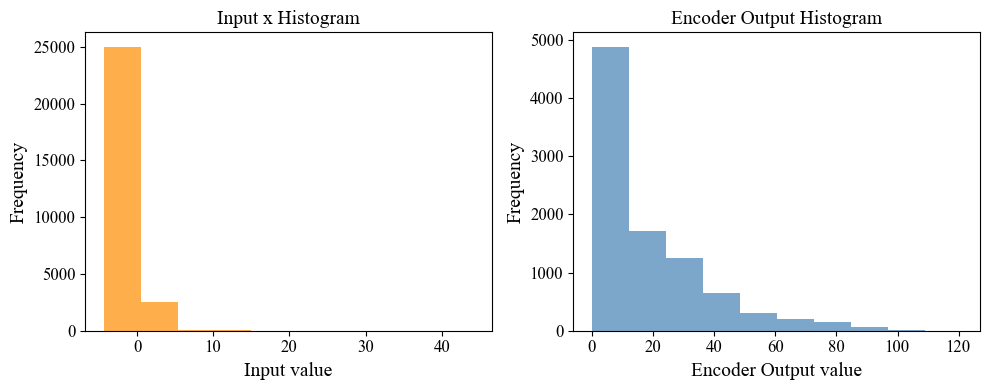

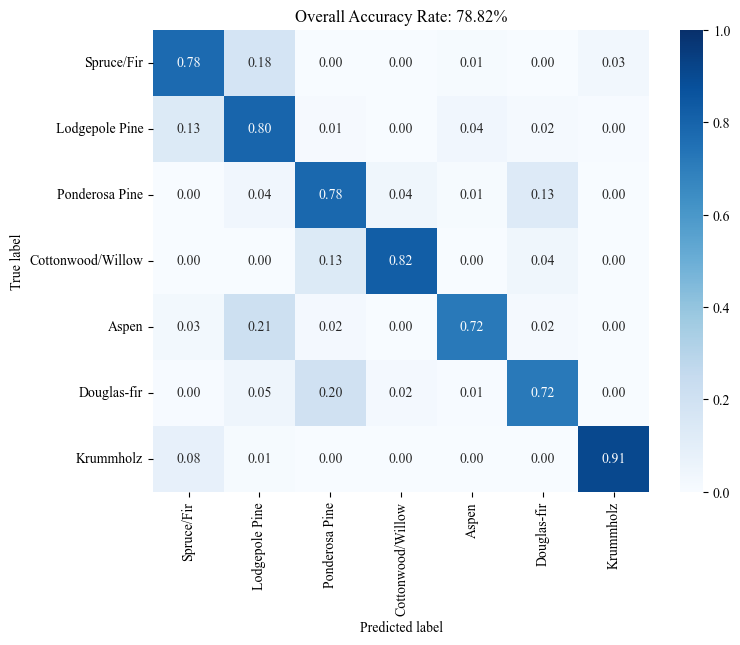

1:3 5th Epoch: 49/50

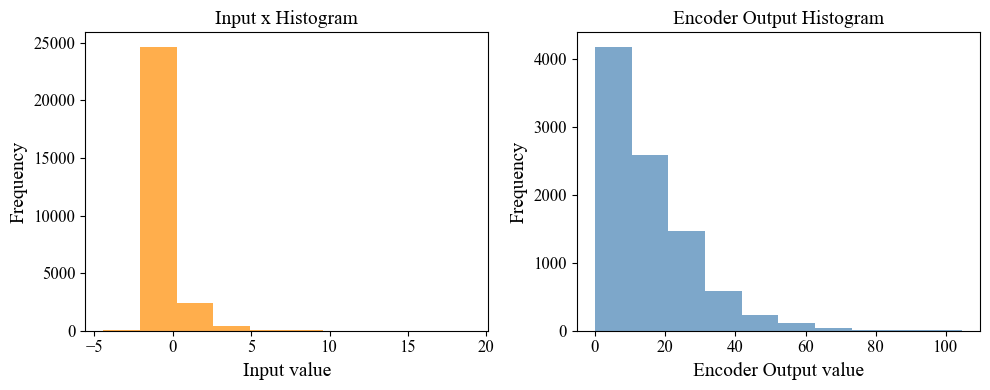

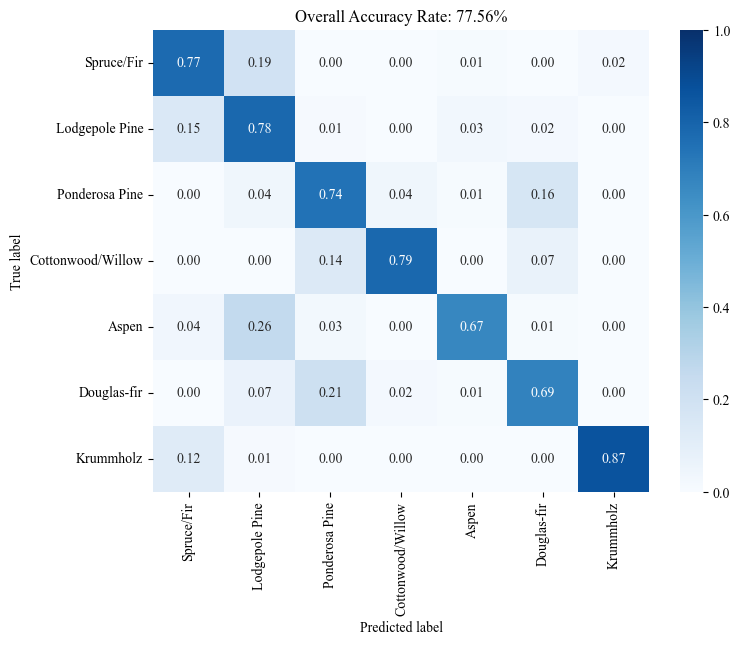

           Average  Best ID       Best  Worst ID      Worst
0   ACC  79.044947        2  80.199306         5  77.557378
1  LOSS   1.062275        2   1.036821         5   1.092476


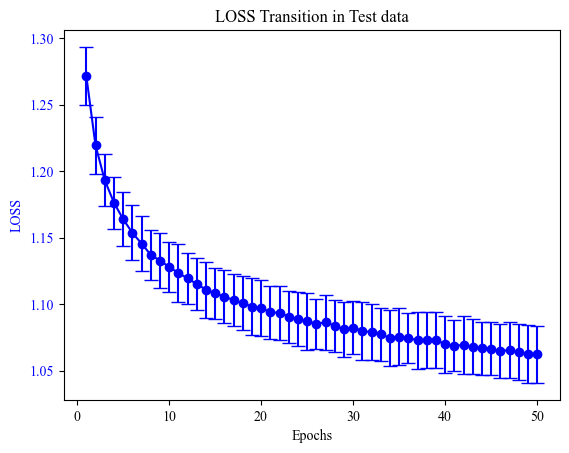

1:6 1th Epoch: 49/50

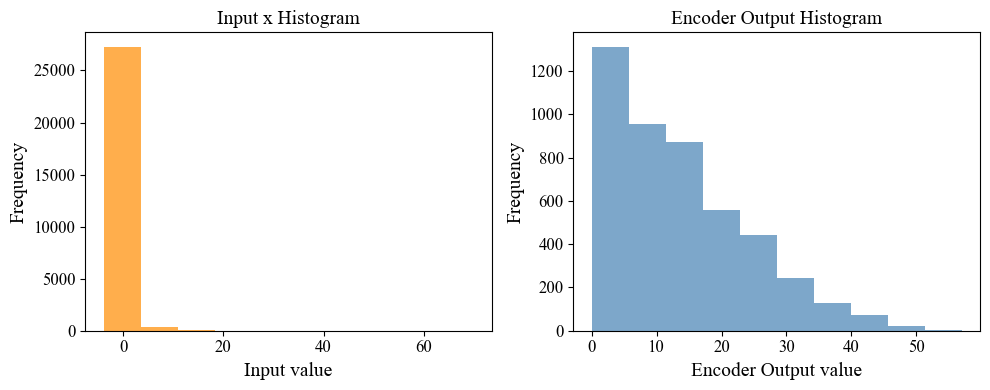

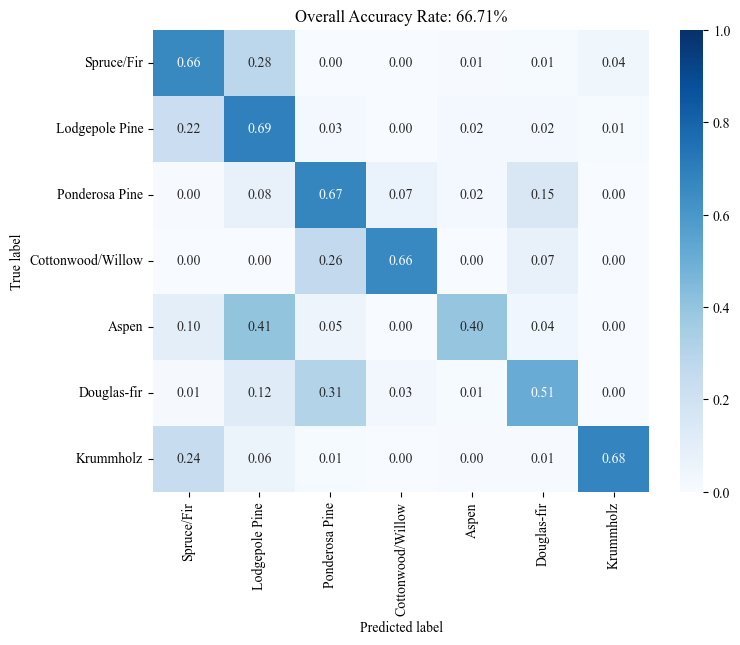

1:6 2th Epoch: 49/50

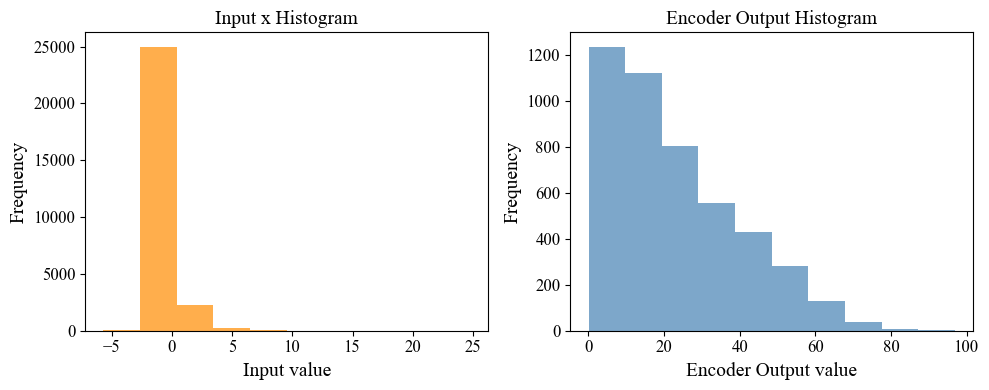

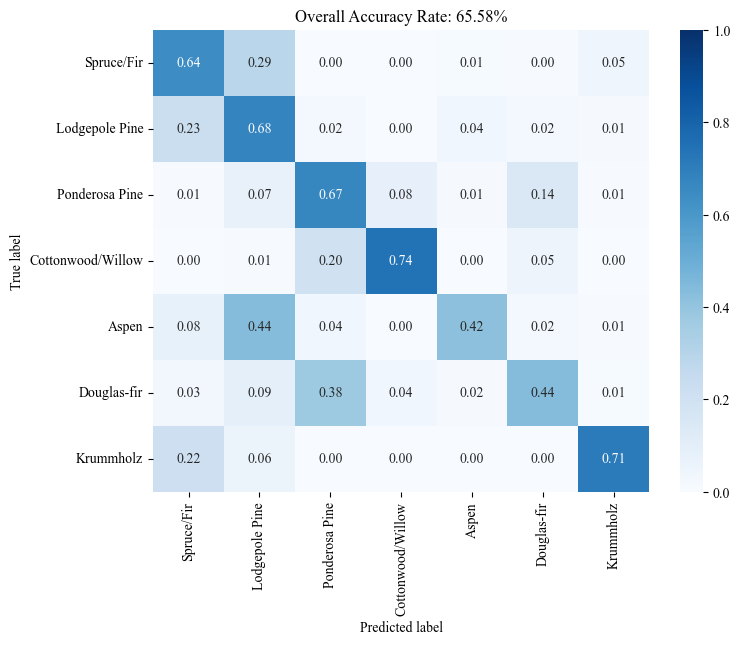

1:6 3th Epoch: 49/50

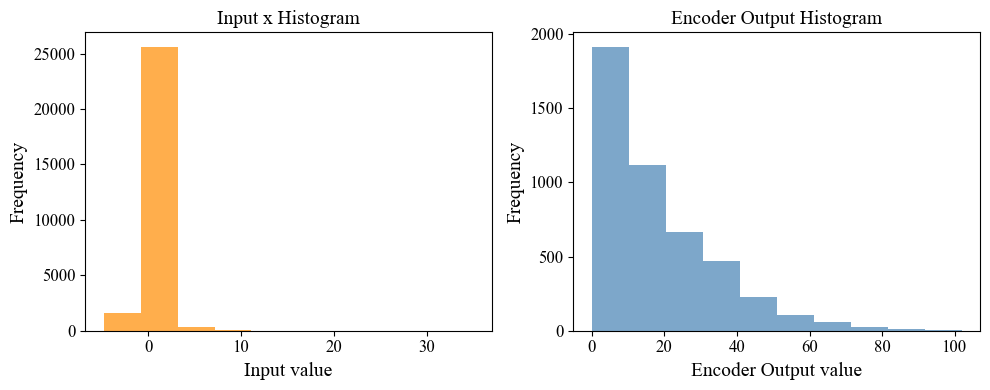

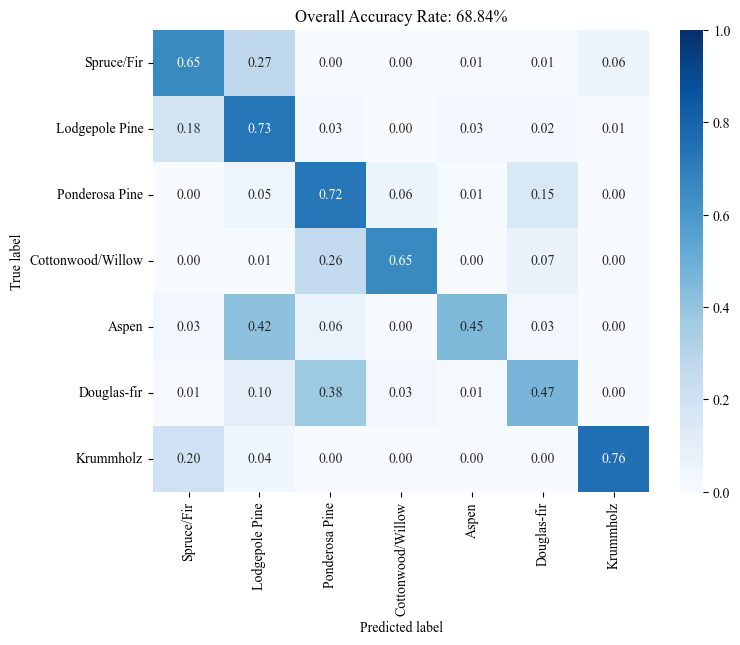

1:6 4th Epoch: 49/50

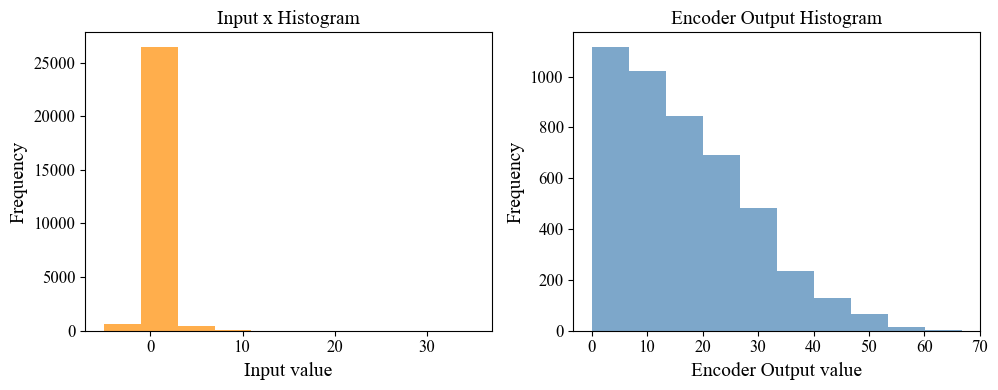

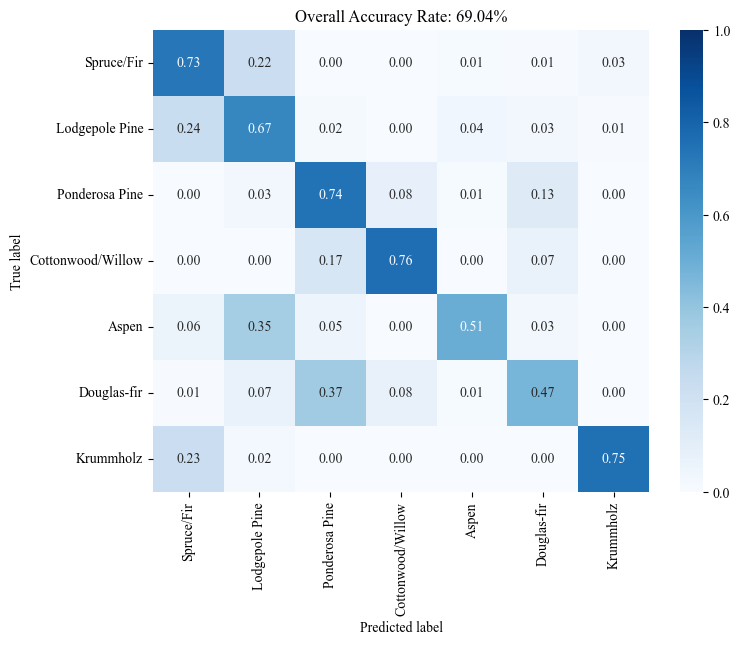

1:6 5th Epoch: 49/50

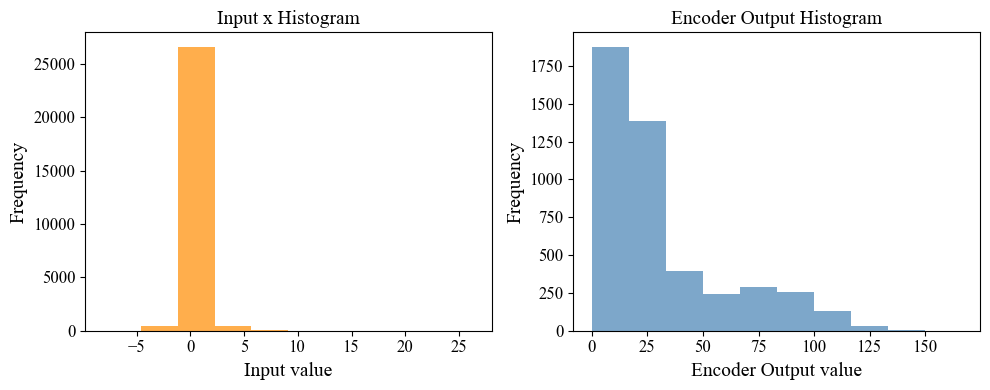

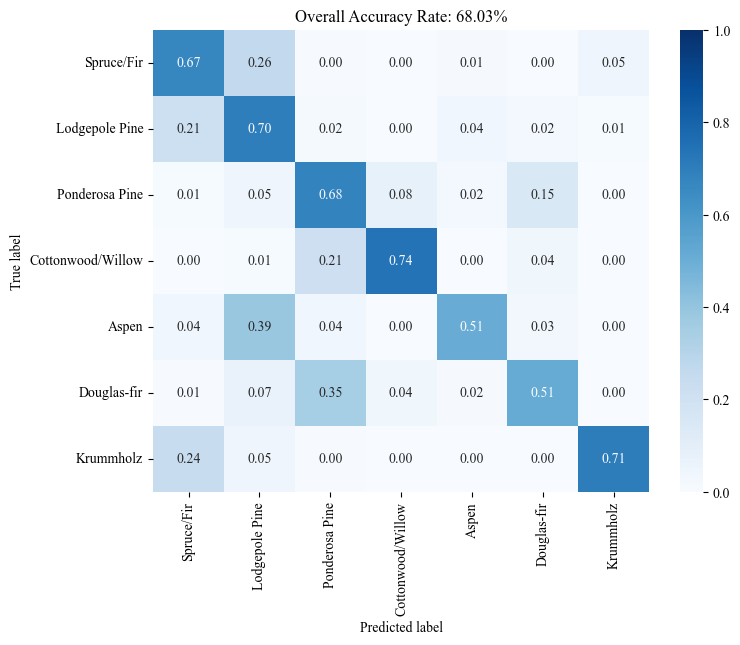

           Average  Best ID       Best  Worst ID      Worst
0   ACC  67.640594        4  69.042968         2  65.579202
1  LOSS   1.288185        4   1.253648         2   1.324441


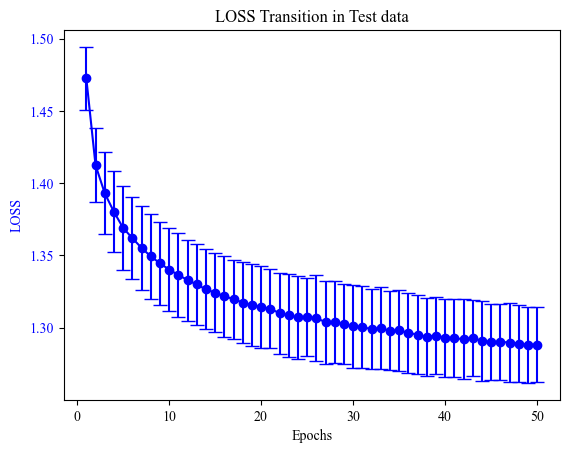

1:9 1th Epoch: 49/50

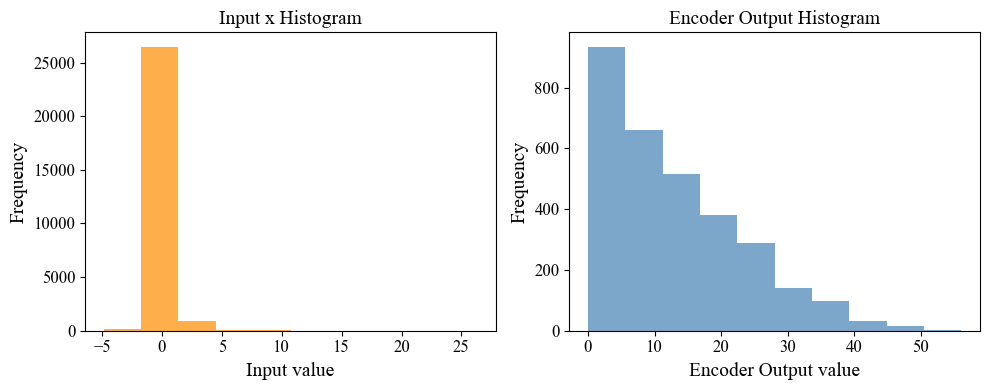

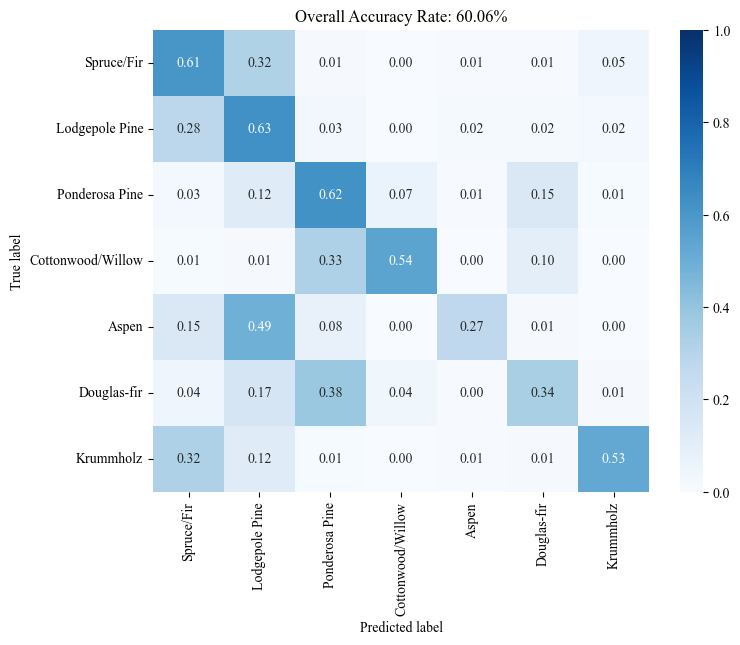

1:9 2th Epoch: 49/50

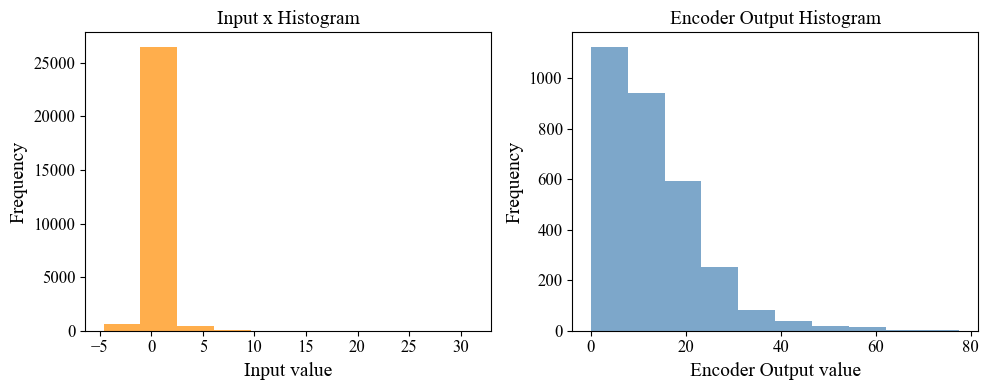

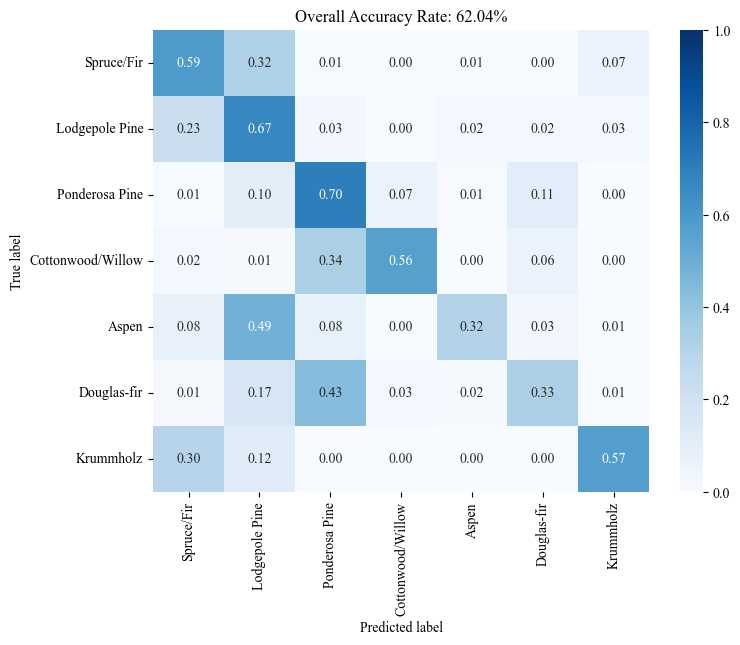

1:9 3th Epoch: 49/50

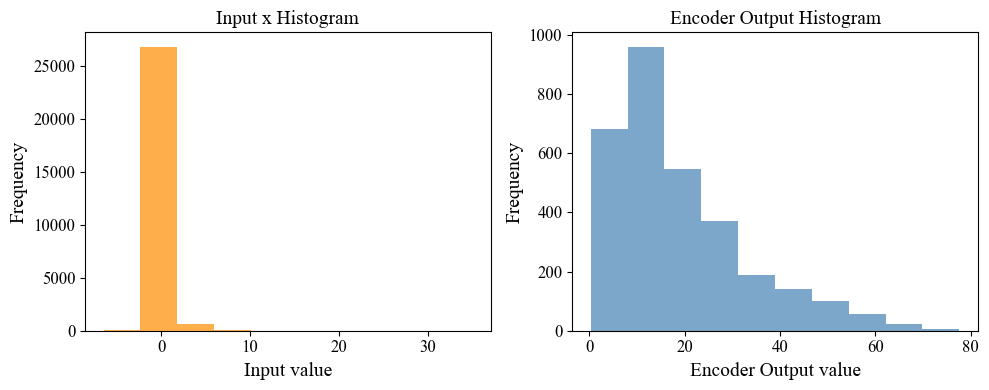

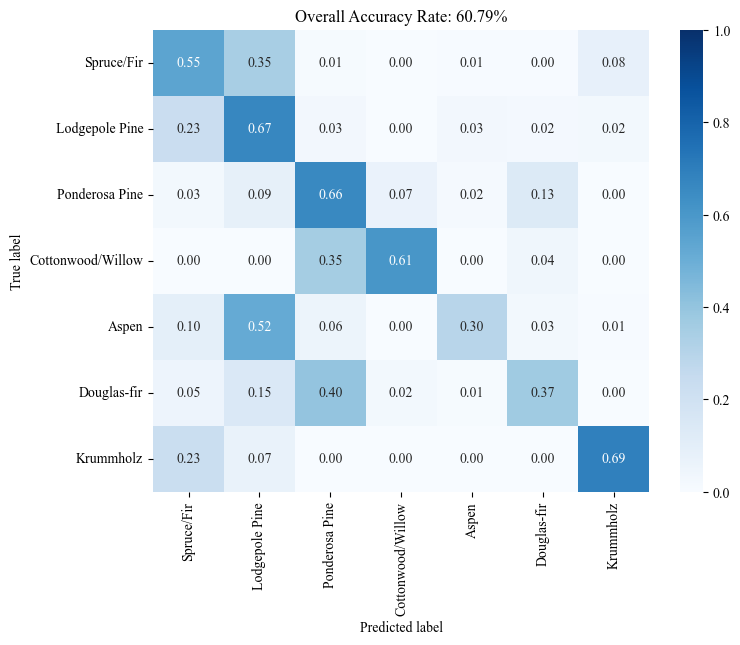

1:9 4th Epoch: 49/50

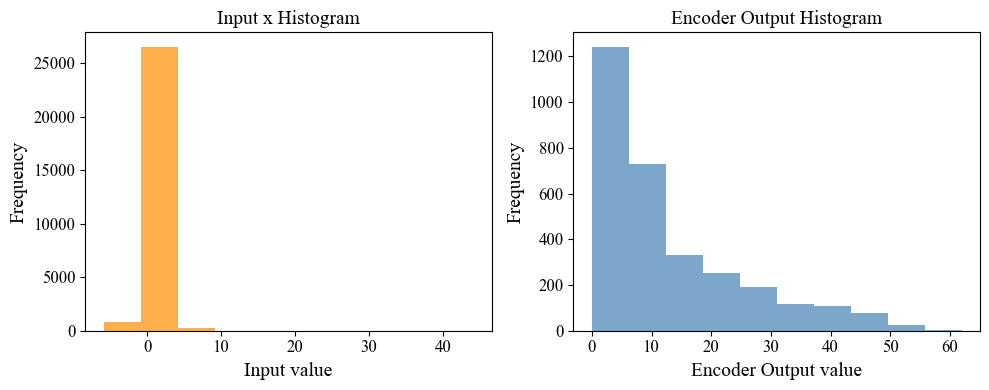

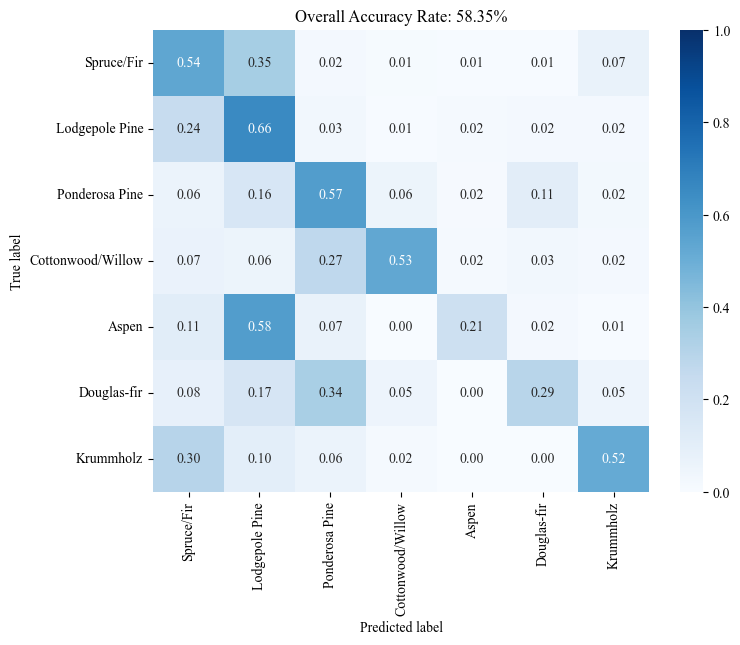

1:9 5th Epoch: 49/50

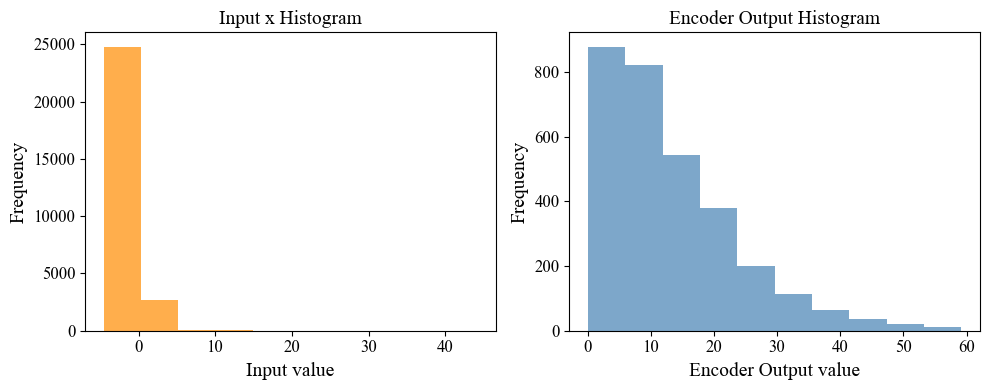

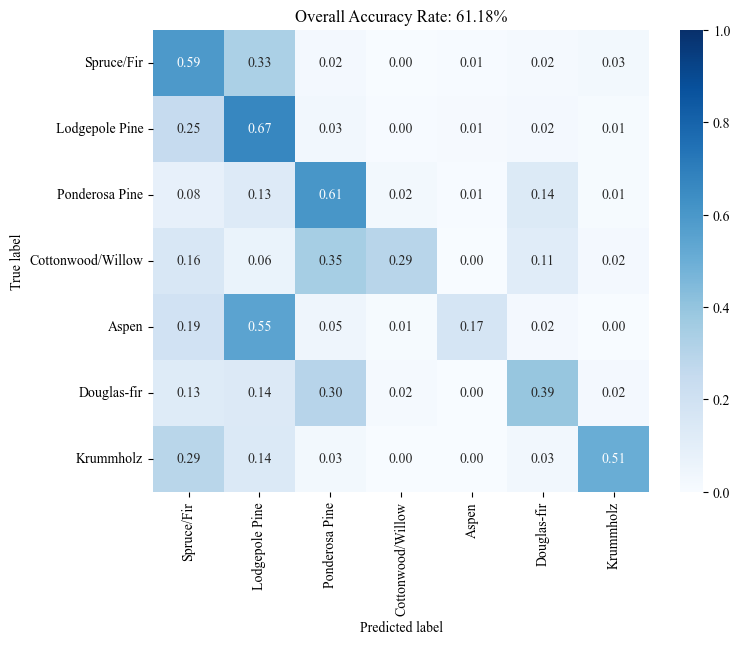

           Average  Best ID       Best  Worst ID      Worst
0   ACC  60.483292        2  62.040567         4  58.348752
1  LOSS   1.459700        3   1.408146         4   1.516644


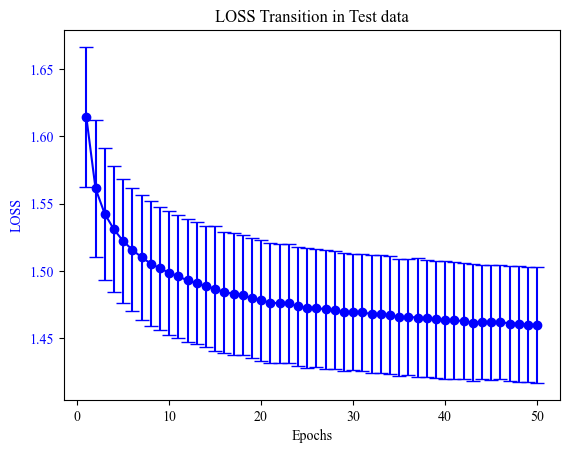

1:18 1th Epoch: 49/50

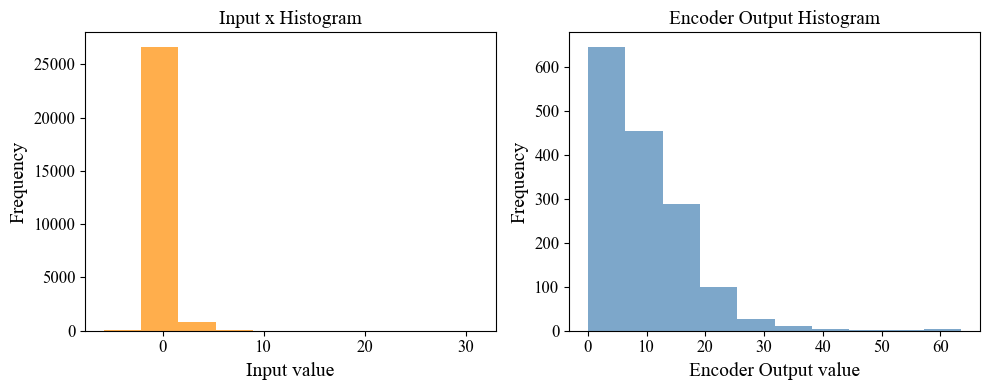

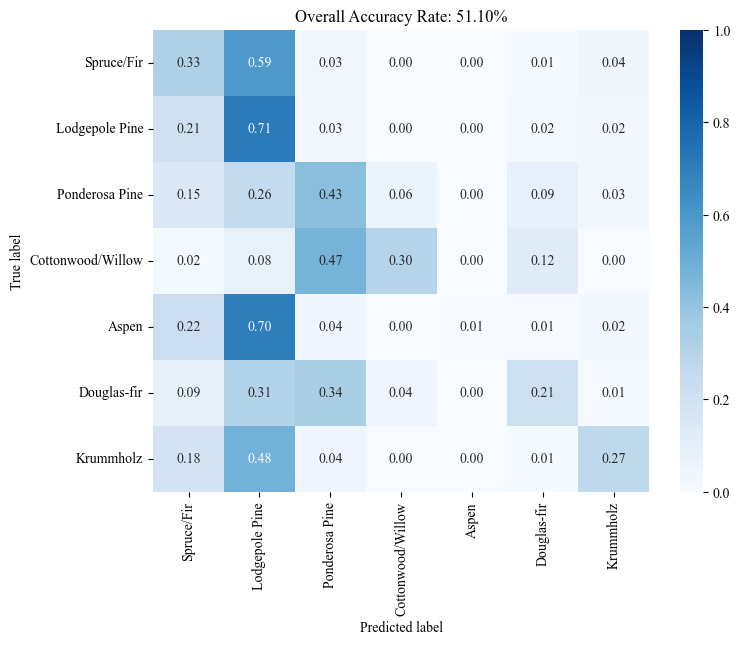

1:18 2th Epoch: 49/50

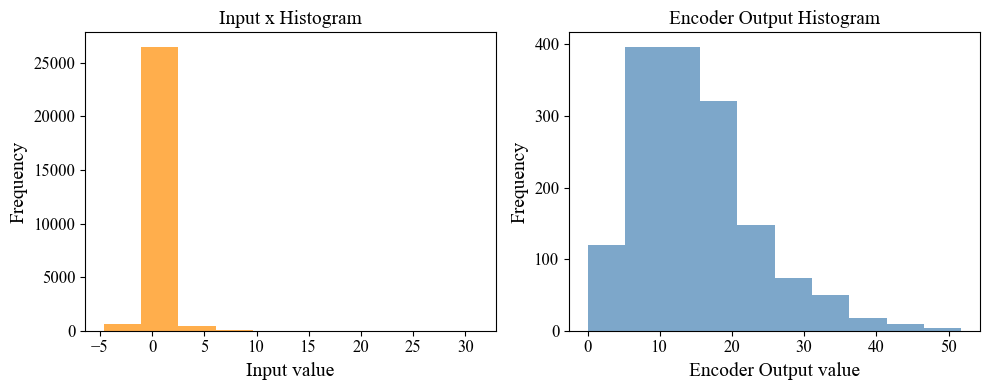

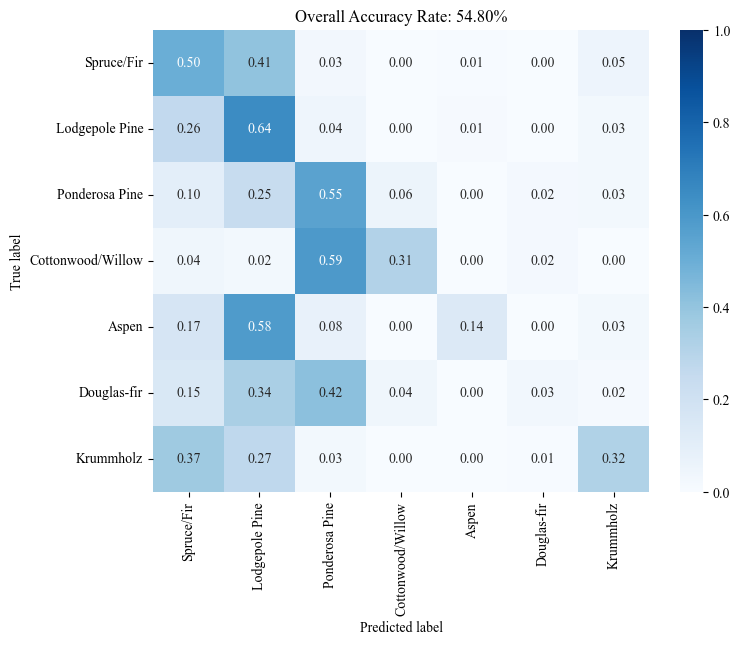

1:18 3th Epoch: 49/50

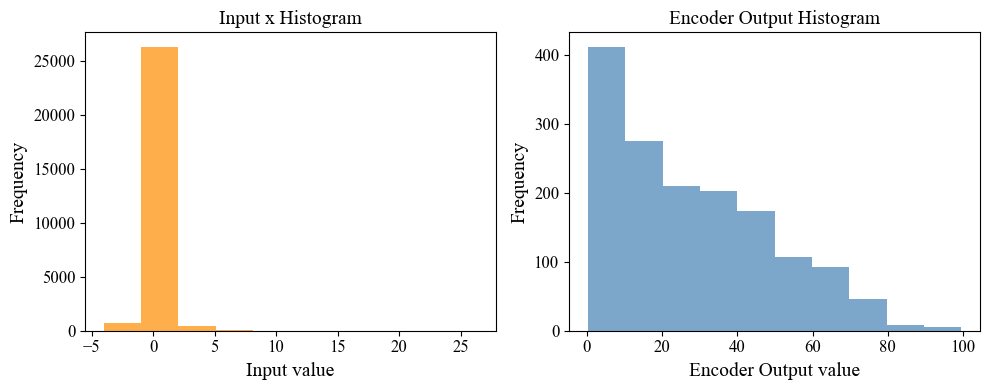

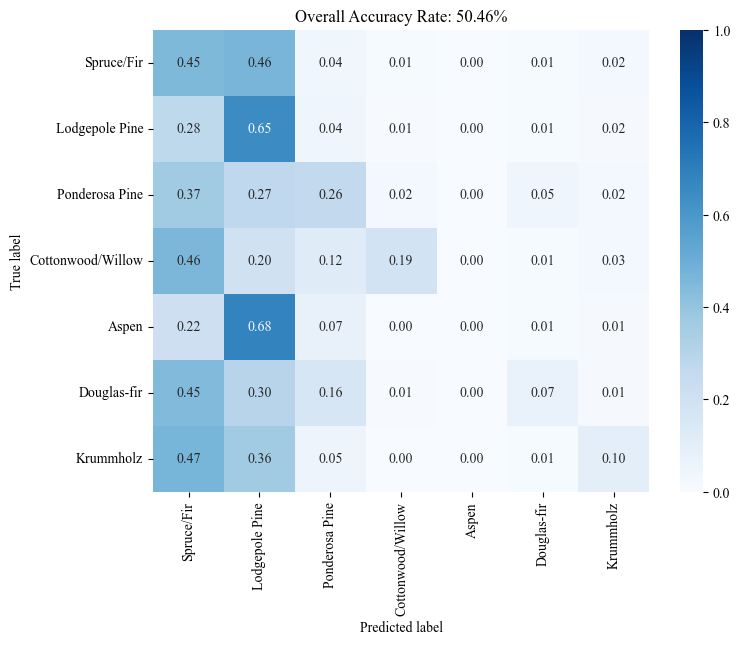

1:18 4th Epoch: 49/50

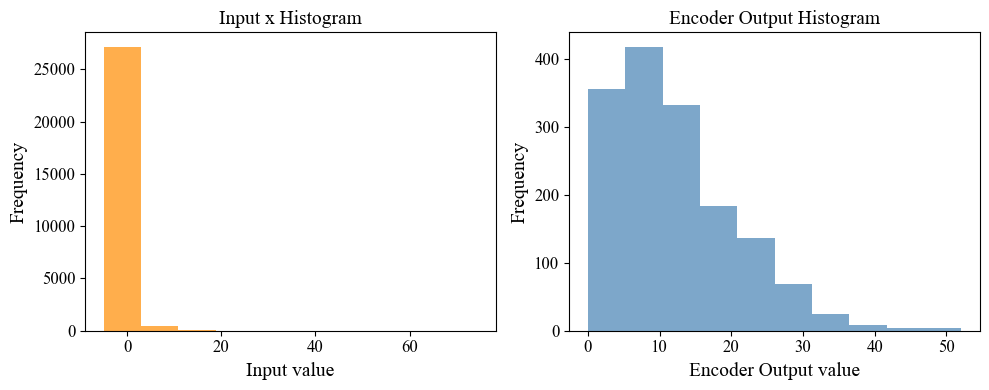

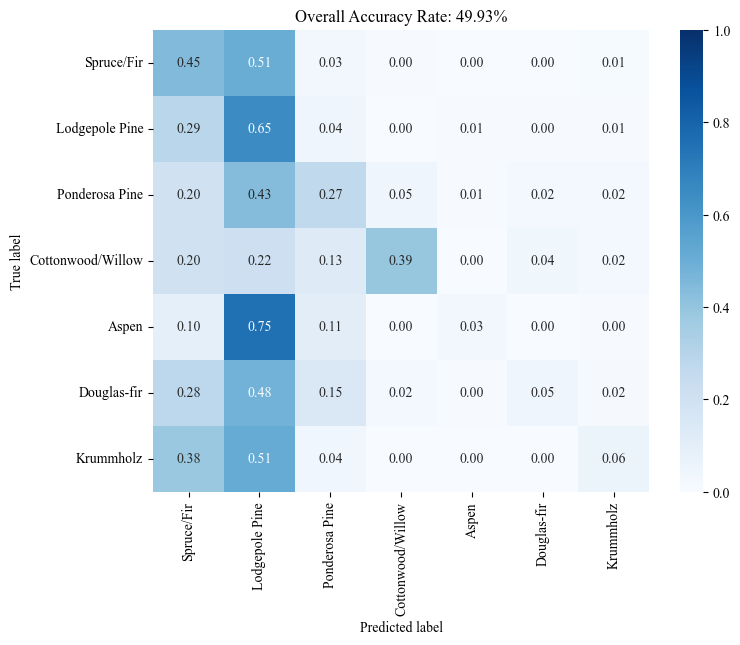

1:18 5th Epoch: 49/50

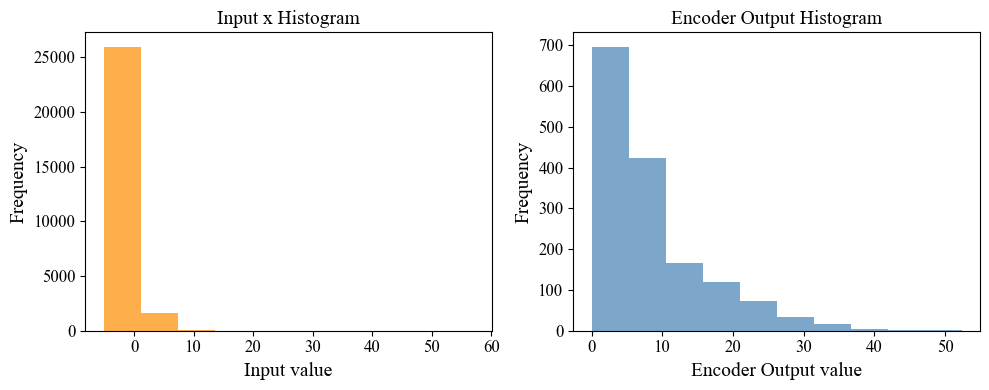

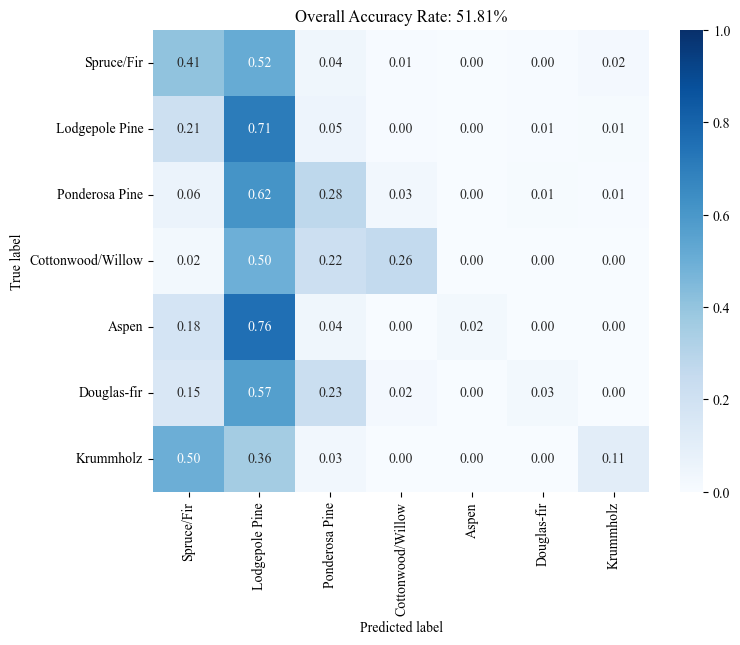

           Average  Best ID       Best  Worst ID      Worst
0   ACC  51.620354        2  54.797208         4  49.934167
1  LOSS   1.730164        2   1.625469         3   1.781340


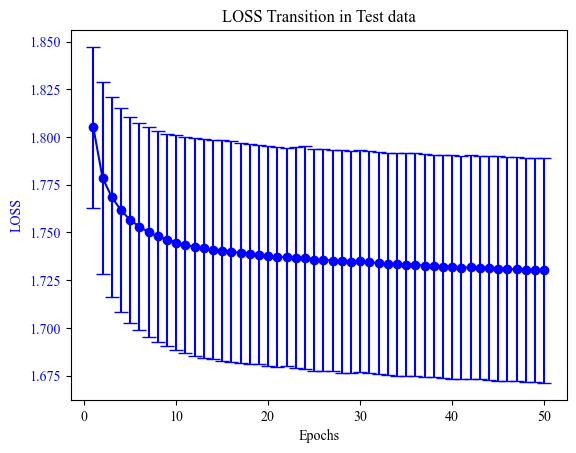

1:27 1th Epoch: 49/50

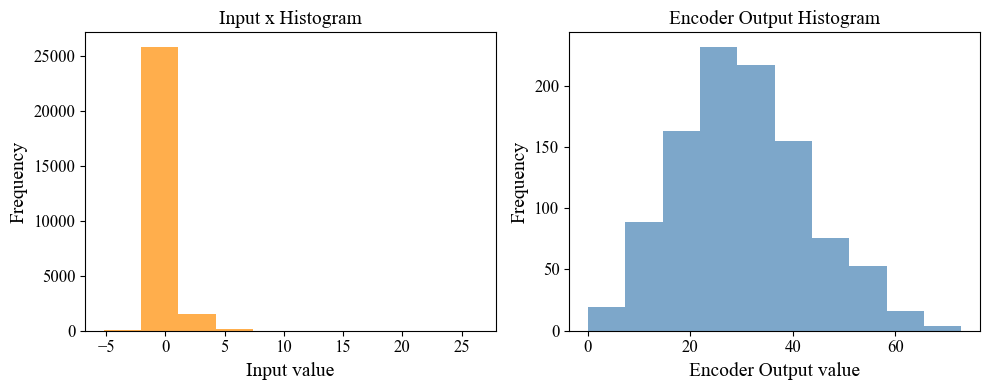

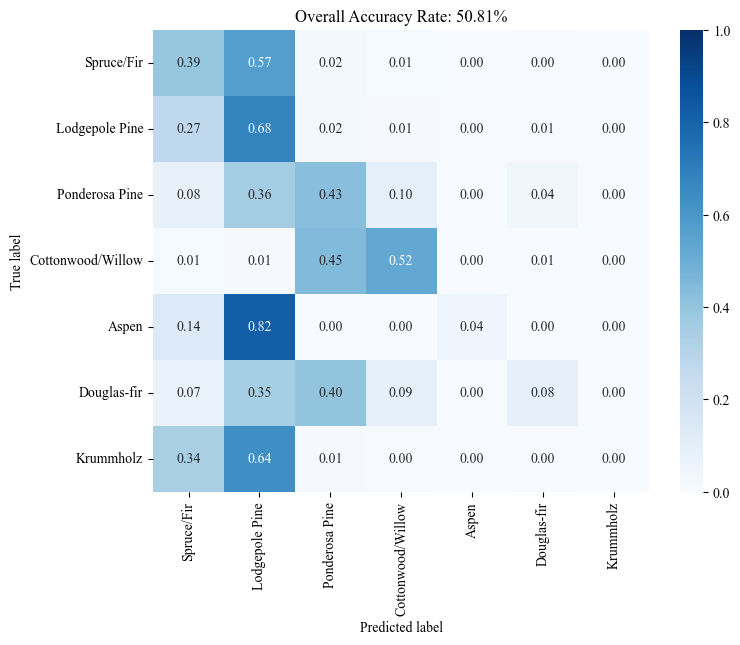

1:27 2th Epoch: 49/50

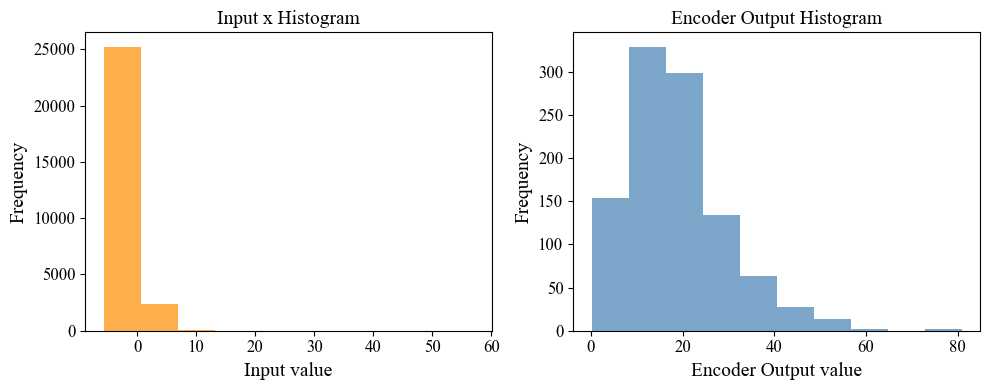

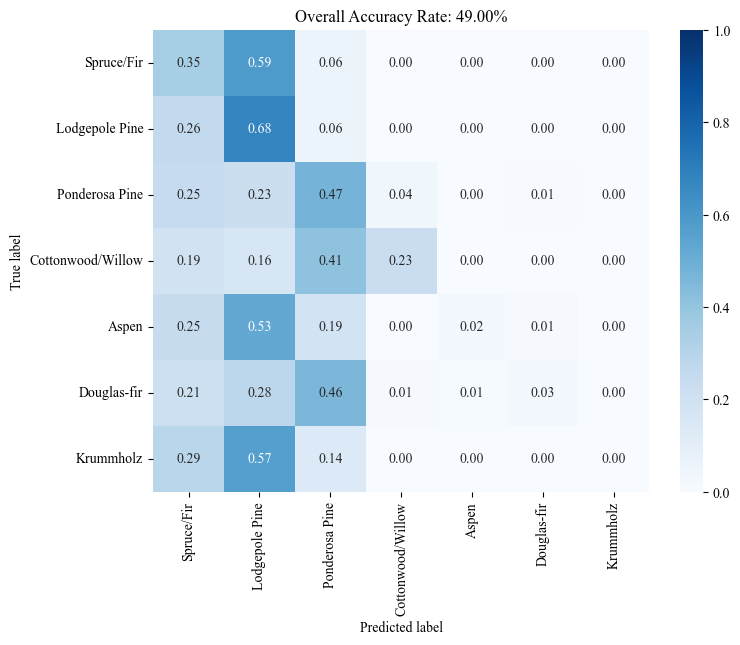

1:27 3th Epoch: 49/50

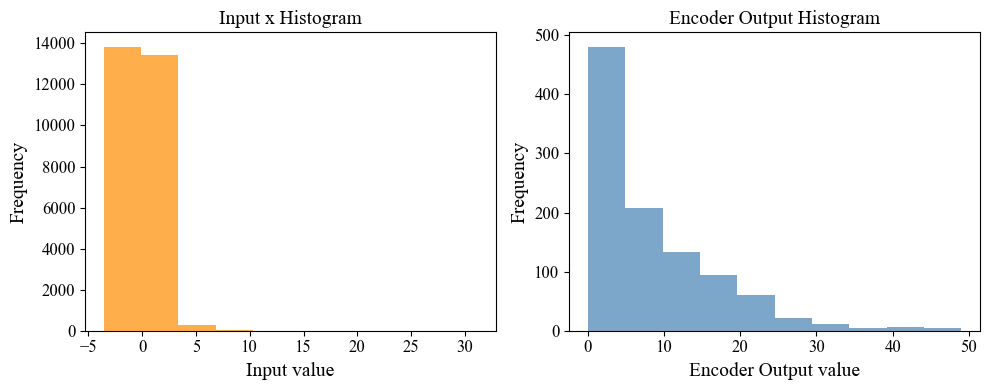

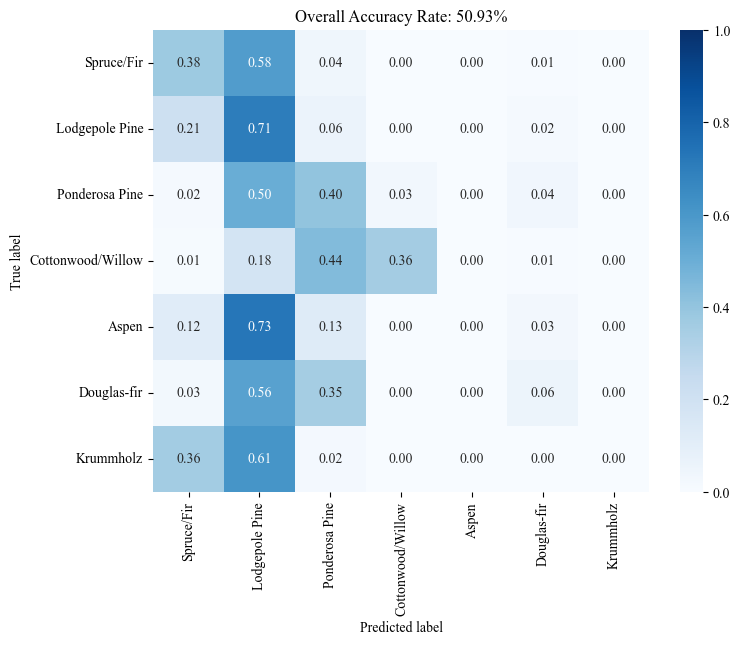

1:27 4th Epoch: 49/50

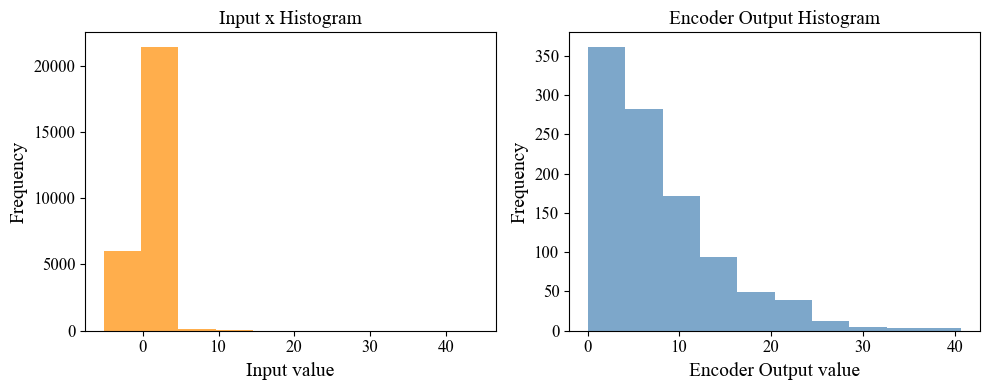

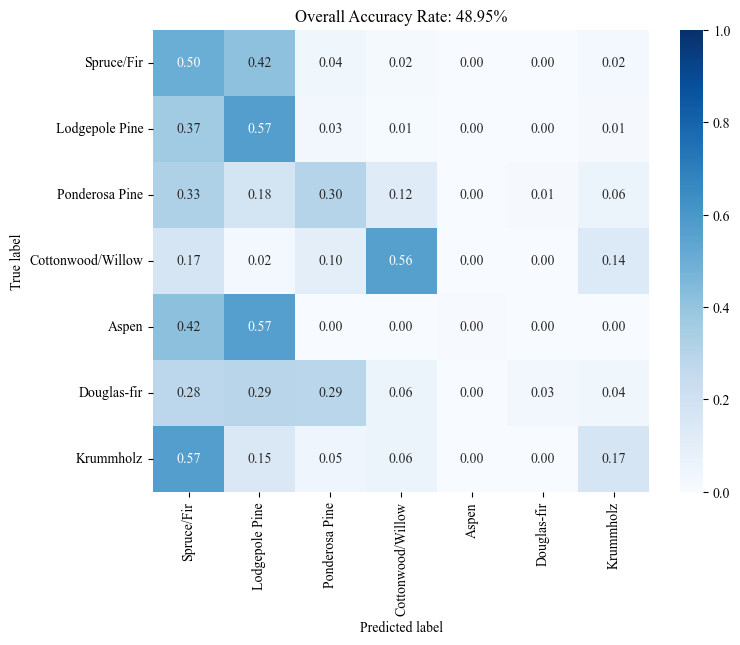

1:27 5th Epoch: 49/50

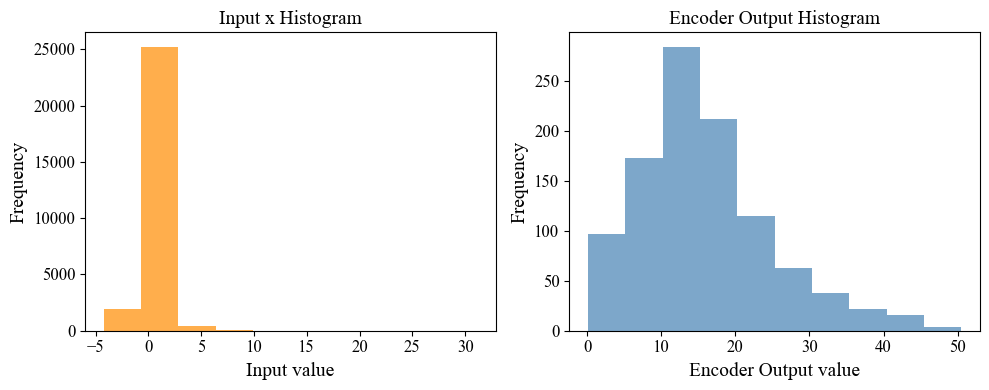

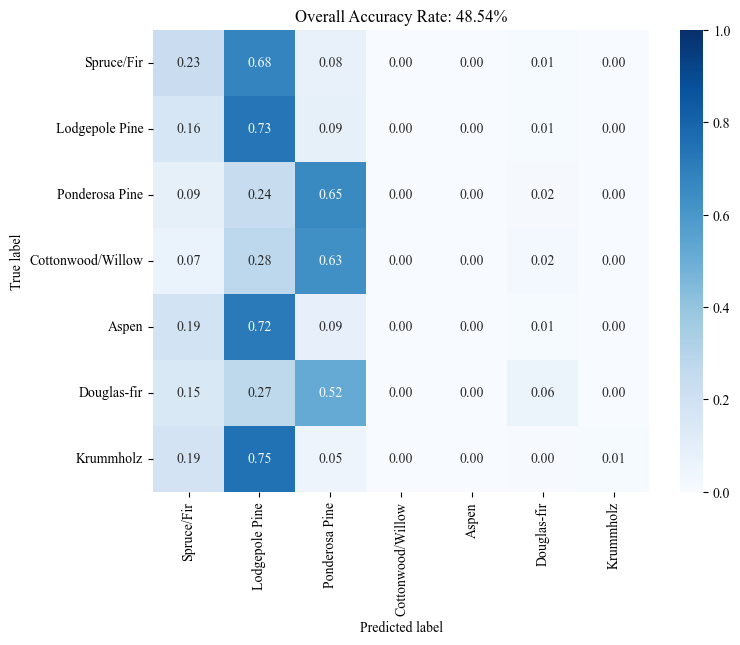

           Average  Best ID       Best  Worst ID      Worst
0   ACC  49.642780        3  50.926396         5  48.539194
1  LOSS   1.753042        1   1.710462         2   1.765952


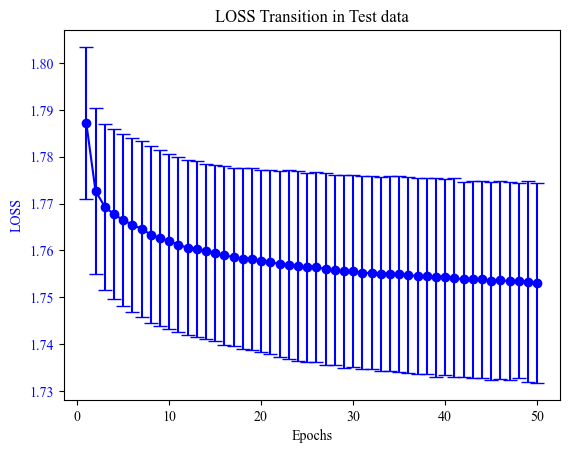

1:54 1th Epoch: 49/50

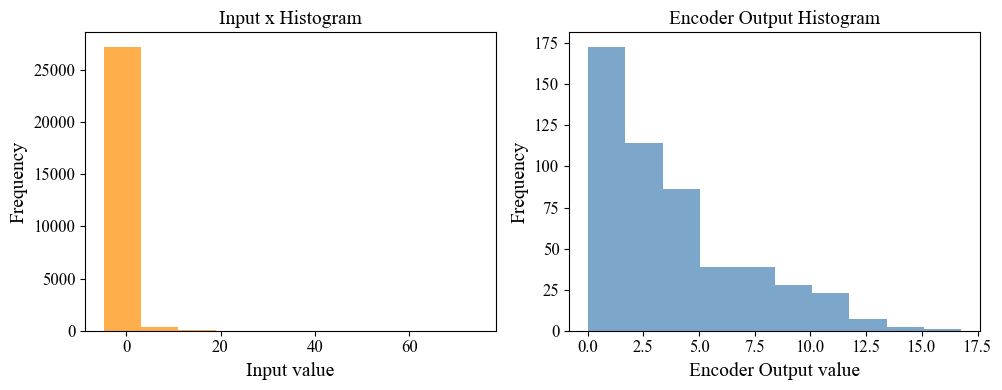

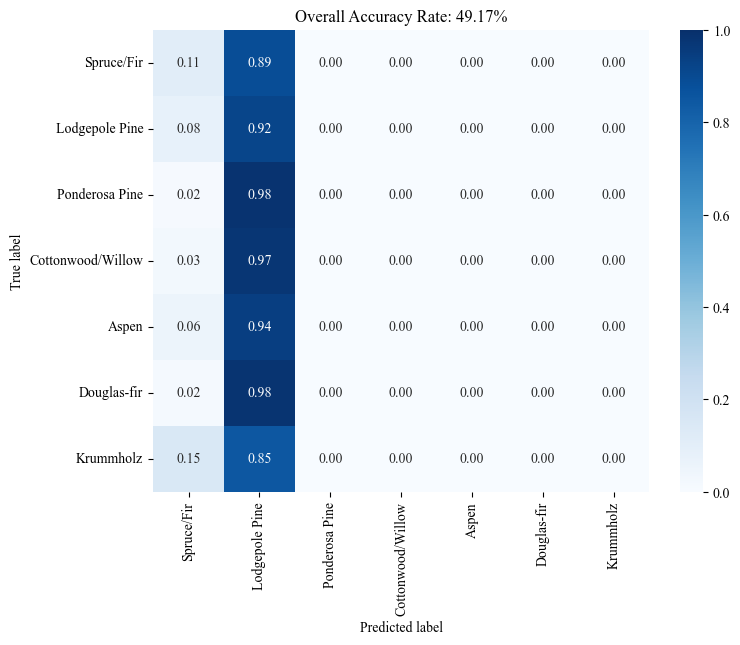

1:54 2th Epoch: 49/50

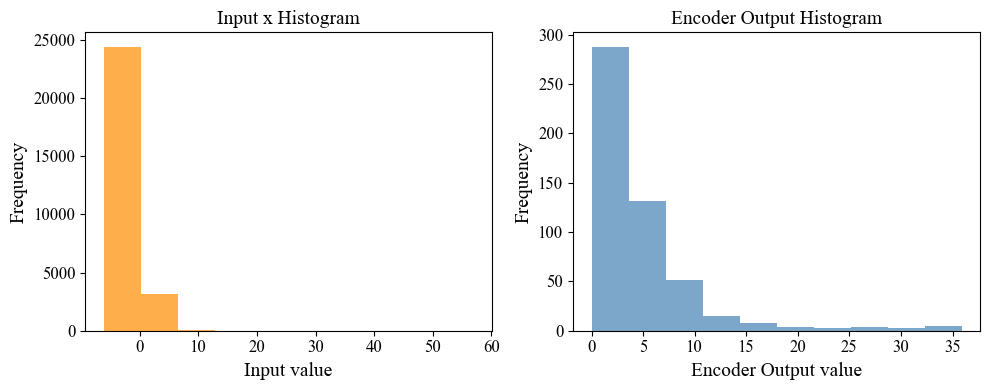

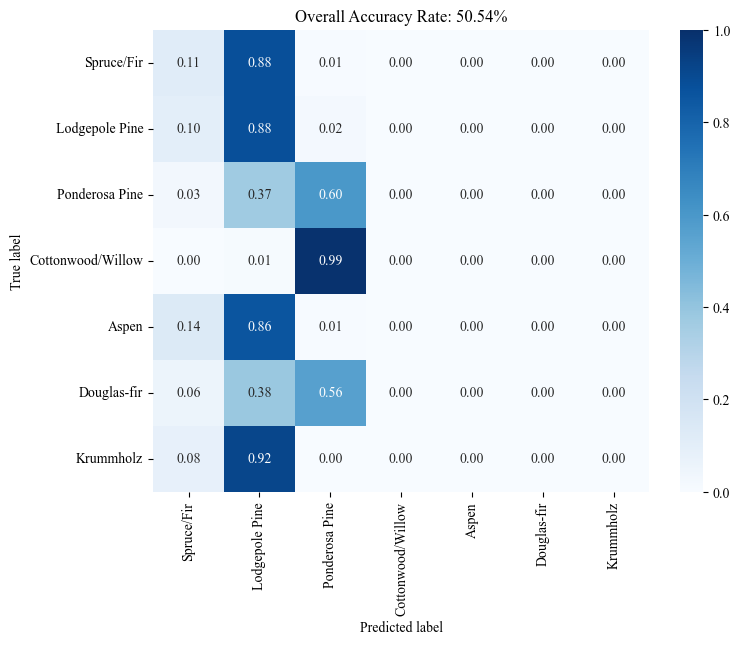

1:54 3th Epoch: 49/50

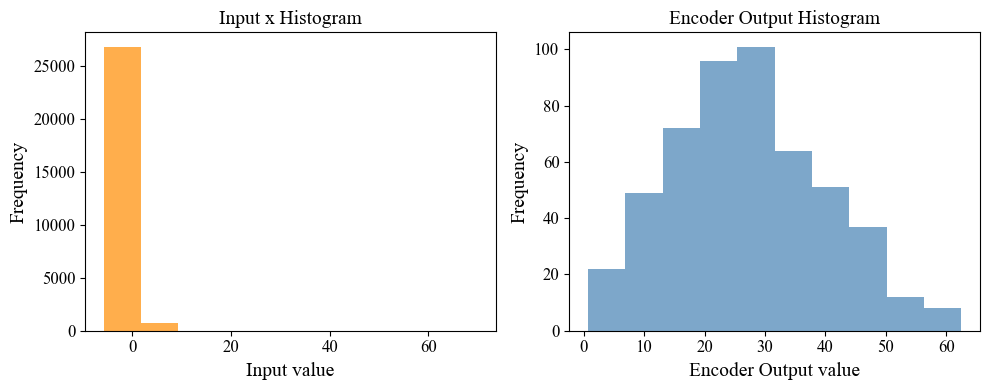

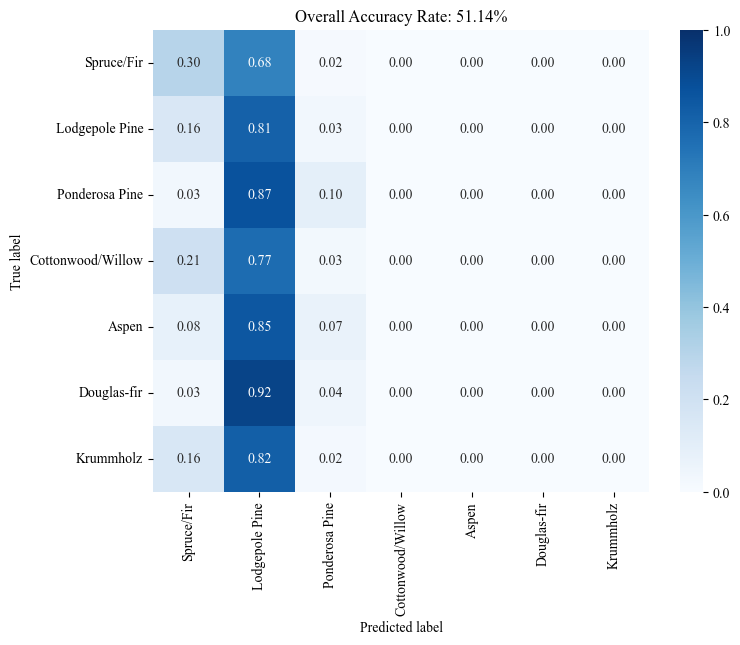

1:54 4th Epoch: 49/50

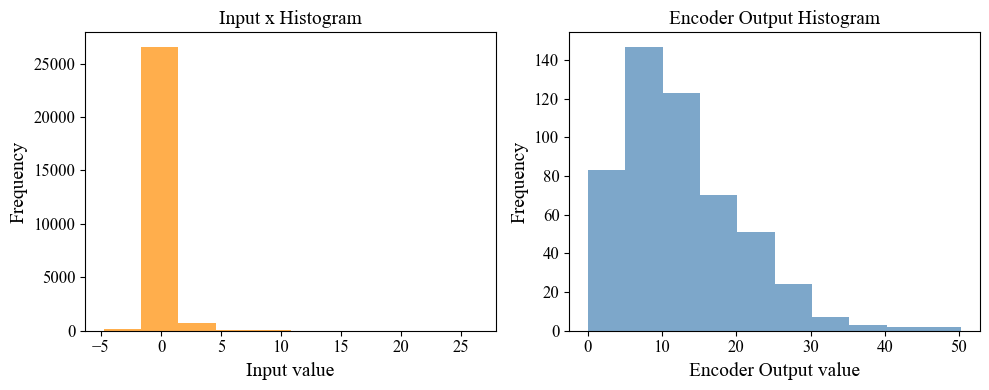

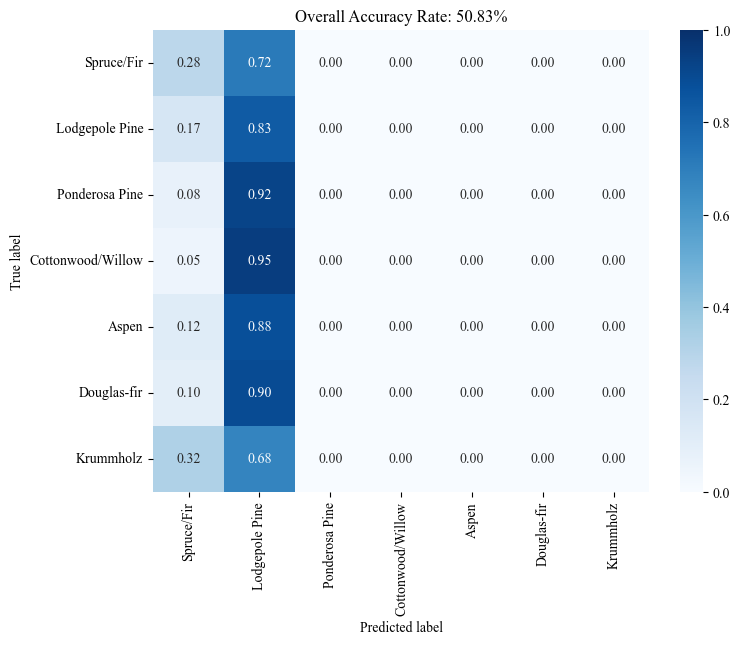

1:54 5th Epoch: 49/50

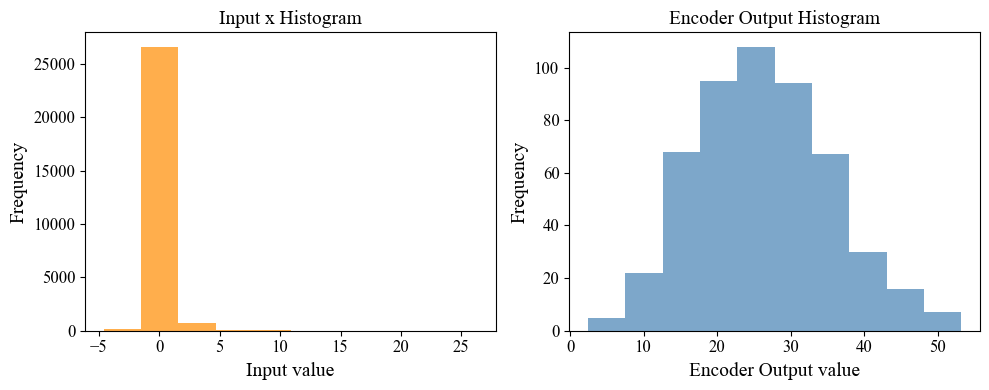

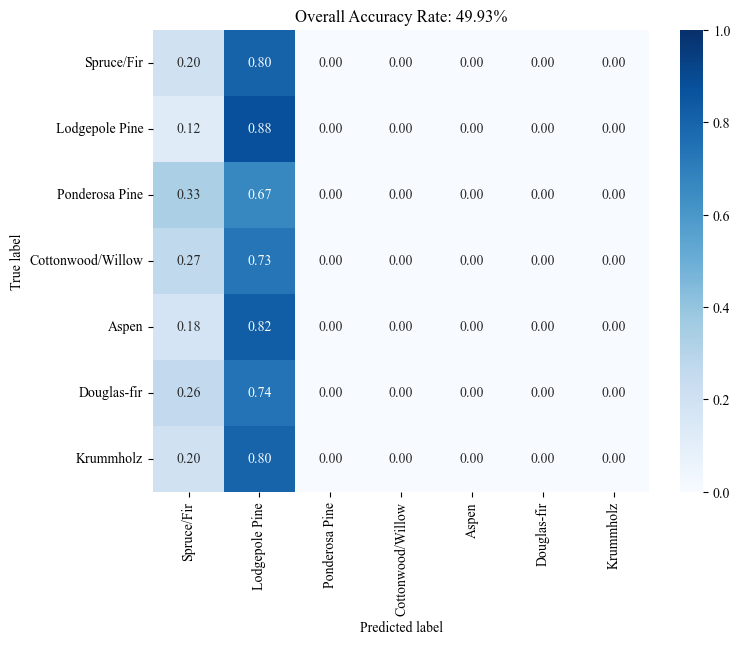

           Average  Best ID       Best  Worst ID      Worst
0   ACC  50.322797        3  51.142397         1  49.169987
1  LOSS   1.871776        2   1.737933         1   1.916564


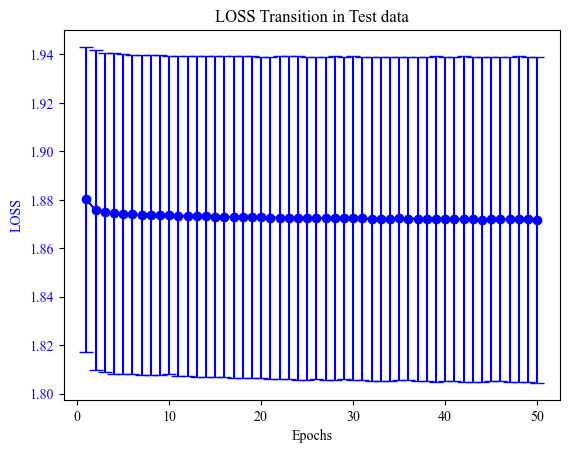

In [36]:
input_dim = X_scaled.shape[1]
print(input_dim)
max_epochs = 50#50
lr = 3e-4 #学習率

num_try = 5##5

leverages = [1,2,3,6,9,18,27,54]
results = []
All_last_LOSSs_ = []
All_last_ACCs_ = []
for leverage in leverages: 
    
    All_last_loss = []
    All_loss_test = []
    All_pro_time = []
    All_test_acc = []

    for num_times in range(1,num_try+1): 
        train_dataloader, test_dataloader = get_new_dataloader(X_scaled,
                                                               y_origin)
        model = EncoderClassifier(input_dim, leverage).to(device)
        counts = np.bincount(y_origin)
        class_w = torch.tensor(1.0 / np.sqrt(counts), 
                               dtype=torch.float32).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_w, label_smoothing=0.05)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        
        loss_train_ = []
        loss_test_ = []
        pro_time_ = []

                
        for epoch in range(max_epochs):

            sys.stderr.write('\r1:%d %dth Epoch: %d/%d' % (leverage,num_times, epoch, max_epochs)) 
            sys.stderr.flush()

            loss_train = 0
            loss_test = 0

            start_time1 = time.time()
            for (x,t) in train_dataloader:
                    
                x, t = x.to(device), t.to(device)
                y = model(x).to(device)
                loss = criterion(y, t) 
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_train += loss.item()
        
            loss_train_avg = loss_train / len(train_dataloader)
            end_time1 = time.time()
            pro_time_.append(end_time1-start_time1)

            model.eval()
            with torch.no_grad():
                all_preds = []
                all_labels = []
                correct = 0
                total = 0
                first_batch = True
                for x, t in test_dataloader:
                    x, t = x.to(device), t.to(device)
                    y = model(x).to(device)
                    _, predicted = torch.max(y, 1)
                    loss = criterion(y,t)
                    loss_test += loss.item()        
                    total += t.size(0)
                    correct += (predicted == t).sum().item()
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(t.cpu().numpy()) 
                    if epoch == max_epochs - 1:
                        if first_batch:

                            x_encoded = model.encoder(x)
                            # サブプロットで横に並べて表示
                            fig, axes = plt.subplots(1, 2, figsize=(10, 4))

                            # 入力ヒストグラム
                            #print(x.shape)
                            x_np = x.view(-1).detach().cpu().numpy()
                            axes[0].hist(x_np, bins=10, color='darkorange', alpha=0.7)
                            axes[0].set_xlabel("Input value", fontsize=14)
                            axes[0].set_ylabel("Frequency", fontsize=14)
                            axes[0].set_title("Input x Histogram", fontsize=14)
                            axes[0].tick_params(labelsize=12)
                            axes[0].set_ylim(0,)
                            
                            # エンコーダ出力ヒストグラム
                            xen_np = x_encoded.reshape(-1).detach().cpu().numpy()
                            axes[1].hist(xen_np, bins=10, color='steelblue', alpha=0.7)
                            axes[1].set_xlabel("Encoder Output value", fontsize=14)
                            axes[1].set_ylabel("Frequency", fontsize=14)
                            axes[1].set_title("Encoder Output Histogram", fontsize=14)
                            axes[1].tick_params(labelsize=12)

                            plt.tight_layout()
                            plt.show()

                            first_batch = False
            
            #print(f"Test Accuracy: {100 * correct / total:.2f}%")
            loss_test_avg = loss_test / len(test_dataloader)

            loss_train_.append(loss_train_avg)
            loss_test_.append(loss_test_avg)
            #if epoch == max_epochs-1:
        All_loss_test.append(loss_test_)
        All_pro_time.append(sum(pro_time_)) 

        cm = confusion_matrix(all_labels, all_preds)
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # 正規化（行ごとに割合に）

        Last_loss_test = loss_test_[-1]
        All_last_loss.append(Last_loss_test)
        Test_acc = 100 * correct / total
        All_test_acc.append(Test_acc)
        labels = [
            "Spruce/Fir",        # 0
            "Lodgepole Pine",    # 1
            "Ponderosa Pine",    # 2
            "Cottonwood/Willow", # 3
            "Aspen",             # 4
            "Douglas-fir",       # 5
            "Krummholz"          # 6
        ]
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                     xticklabels=labels, yticklabels=labels,vmin=0.0, vmax=1.0)
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title(f"Overall Accuracy Rate: {Test_acc:.2f}%")
        plt.show()

    All_last_LOSSs_.append(All_last_loss)
    All_last_ACCs_.append(All_test_acc)
    
    ACC_mean = np.mean(All_test_acc)
    ACC_best = np.max(All_test_acc)
    ACC_bestID = np.argmax(All_test_acc)+1
    ACC_worst = np.min(All_test_acc)
    ACC_worstID = np.argmin(All_test_acc)+1

    LOSS_mean = np.mean(All_last_loss)
    LOSS_best = np.min(All_last_loss)
    LOSS_bestID = np.argmin(All_last_loss)+1
    LOSS_worst = np.max(All_last_loss)
    LOSS_worstID = np.argmax(All_last_loss)+1

    data = {
            "": ["ACC", "LOSS"],
        "Average": [ACC_mean, LOSS_mean],
        "Best ID": [ACC_bestID, LOSS_bestID],
        "Best": [ACC_best, LOSS_best],
        "Worst ID": [ACC_worstID, LOSS_worstID],
        "Worst": [ACC_worst, LOSS_worst],
    }

    df = pd.DataFrame(data)
    results.append(data)
    print(df)
    epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
    num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

    # 各エポックごとに平均と標準偏差を計算
    mean_loss = np.mean(All_loss_test, axis=0)
    std_loss = np.std(All_loss_test, axis=0)

    # グラフの描画
    fig, ax1 = plt.subplots()

    # 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
    ax1.errorbar(
        x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
        fmt='-o', color='blue', ecolor='blue', capsize=5, 
    )

    # 軸ラベルやタイトルの設定
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LOSS', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    plt.title('LOSS Transition in Test data')
    #plt.ylim(0,1.0)
    plt.show()


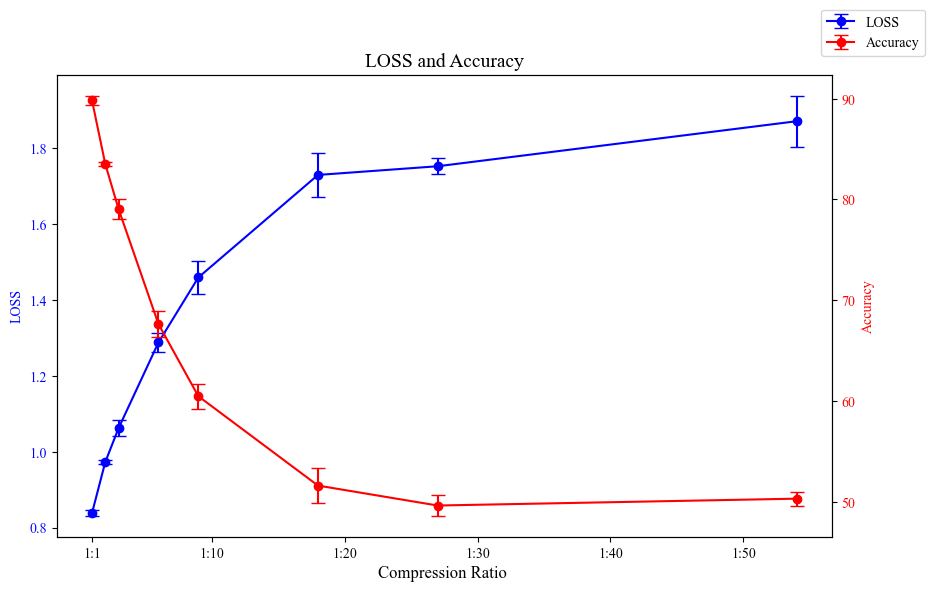

In [37]:
# 横軸の値 (1/leverage)
x_values = [leverage for leverage in leverages]
memory_lis =[1,10,20,30,40,50]

# LOSS用の平均値と標準偏差を計算
loss_means = [np.mean(loss_list) for loss_list in All_last_LOSSs_]
loss_stds = [np.std(loss_list) for loss_list in All_last_LOSSs_]

# ACC用の平均値と標準偏差を計算
acc_means = [np.mean(acc_list) for acc_list in All_last_ACCs_]
acc_stds = [np.std(acc_list) for acc_list in All_last_ACCs_]

# グラフの描画
fig, ax1 = plt.subplots(figsize=(10, 6))

# MSEのエラーバー付き折れ線グラフ
ax1.errorbar(
    x=x_values, y=loss_means, yerr=loss_stds,
    fmt='-o', color='blue', ecolor='blue', capsize=5, label='LOSS'
)
ax1.set_ylabel('LOSS', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
# SSIMのエラーバー付き折れ線グラフ
ax2.errorbar(
    x=x_values, y=acc_means, yerr=acc_stds,
    fmt='-o', color='red', ecolor='red', capsize=5, label='Accuracy'
)
ax2.set_ylabel('Accuracy', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 軸ラベルとスケールの設定
ax1.set_xlabel('Compression Ratio ', fontsize=12)

ax1.set_xticks(memory_lis)
ax1.set_xticklabels([f"1:{x}" for x in memory_lis]) # ラベルを「1:N」形式で表示

# タイトルと凡例
plt.title('LOSS and Accuracy', fontsize=14)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    lines1 + lines2, labels1 + labels2, loc="upper right", bbox_to_anchor=(1, 1)
)
plt.show()

In [38]:
all_data = pd.concat([pd.DataFrame(result) for result in results], ignore_index=True)
print(all_data)

            Average  Best ID       Best  Worst ID      Worst
0    ACC  89.830727        1  90.353950         5  89.250708
1   LOSS   0.838087        1   0.827797         3   0.845328
2    ACC  83.509032        2  83.660491         5  83.072726
3   LOSS   0.972874        2   0.964183         1   0.977686
4    ACC  79.044947        2  80.199306         5  77.557378
5   LOSS   1.062275        2   1.036821         5   1.092476
6    ACC  67.640594        4  69.042968         2  65.579202
7   LOSS   1.288185        4   1.253648         2   1.324441
8    ACC  60.483292        2  62.040567         4  58.348752
9   LOSS   1.459700        3   1.408146         4   1.516644
10   ACC  51.620354        2  54.797208         4  49.934167
11  LOSS   1.730164        2   1.625469         3   1.781340
12   ACC  49.642780        3  50.926396         5  48.539194
13  LOSS   1.753042        1   1.710462         2   1.765952
14   ACC  50.322797        3  51.142397         1  49.169987
15  LOSS   1.871776     

In [39]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_Classifer', 'data','Cover_texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'MLP_VCR_PM_Class00_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_last_LOSSs_)
    writer.writerow(All_last_ACCs_)

/Users/konishi/Library/CloudStorage/OneDrive-個人用(2)/CODES/konishi_Classifer/data/Cover_texts
